In [1]:
%matplotlib inline

import cv2, matplotlib
import numpy as np
from skimage.morphology import (
    skeletonize,
    skeletonize_3d,
    medial_axis,
    thin,
    local_minima,
    local_maxima,
)
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.ndimage import distance_transform_edt

from math import sqrt

import matplotlib.pyplot as plt

from os.path import expanduser, splitext
from os import scandir, makedirs

# import random

import csv

from tqdm import tnrange, tqdm_notebook

from pathlib import Path

debug = True  # plot every steps

In [2]:
def read_from_csv(filepath):
    if Path(filepath).is_file():

        with open(filepath, "r", newline="", encoding="utf-8-sig") as csvfile:
            listreader = csv.reader(csvfile)
            columns = next(listreader)
            readlist = list(listreader)

    else:
        columns = []
        readlist = []

    return columns, readlist


def read_bgr_from_image_unicode(path):
    """workaround for non-ascii filenames"""

    stream = open(path, "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)
    bgr = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)

    return bgr


def save_bgr_to_image_unicode(bgr, path, ext_to=".png"):
    """workaround for non-ascii filenames"""

    _, numpyarray = cv2.imencode(ext_to, bgr)
    with open(path, "wb") as file:
        file.write(numpyarray)

# unit mask

In [3]:
def color_dict_mask(
    img_dict={
        "Lab": np.zeros((1, 1, 3), dtype="uint8"),
        "HSV": np.zeros((1, 1, 3), dtype="uint8"),
    },
    colors={
        "colorname": {
            "Lab": ([0, 0, 0], [255, 255, 255]),
            "HSV": ([0, 0, 0], [255, 255, 255]),
        }
    },
):
    # get masks matching any of the colors matching all descriptions

    mask = np.zeros_like(list(img_dict.values())[0][:, :, 0])
    for color_dict in colors.values():
        mask_color = np.ones_like(mask) * 255
        for colorspace, limits in color_dict.items():
            mask_colorspace = cv2.inRange(
                img_dict[colorspace], np.array(limits[0]), np.array(limits[1])
            )
            mask_color = cv2.bitwise_and(mask_color, mask_colorspace)

        mask = cv2.bitwise_or(mask, mask_color)

    return mask


def get_color_mask(
    blur={
        "Lab": np.zeros((1, 1, 3), dtype="uint8"),
        "HSV": np.zeros((1, 1, 3), dtype="uint8"),
    },
    colors={
        "colorname": {
            "Lab": ([0, 0, 0], [255, 255, 255]),
            "HSV": ([0, 0, 0], [255, 255, 255]),
        }
    },
):
    #     lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2Lab)

    #     blur = {}
    #     blur["Lab"] = cv2.bilateralFilter(lab, 15, 25, 150)
    #     blur["BGR"] = cv2.cvtColor(blur["Lab"], cv2.COLOR_Lab2BGR)
    #     blur["HSV"] = cv2.cvtColor(blur["BGR"], cv2.COLOR_BGR2HSV)

    # get masks matching any of the colors matching all descriptions

    mask = color_dict_mask(blur, colors)

    # fill holes and remove noise

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    holes = [contours[i] for i in range(len(contours)) if hierarchy[0][i][3] >= 0]
    cv2.drawContours(mask, holes, -1, 255, -1)

    kernel_5c = np.array(
        [
            [0, 1, 1, 1, 0],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [0, 1, 1, 1, 0],
        ],
        dtype=np.uint8,
    )

    kernel_9c = np.zeros((9, 9), np.uint8)
    cv2.circle(kernel_9c, (4, 4), 4, 1, -1)

    kernel_15c = np.zeros((15, 15), np.uint8)
    cv2.circle(kernel_15c, (7, 7), 7, 1, -1)

    # mask = cv2.erode(mask, kernel_5c, iterations=1)

    smallbits = [
        contours[i]
        for i in range(len(contours))
        if hierarchy[0][i][3] == -1 and cv2.contourArea(contours[i]) <= 100
    ]
    cv2.drawContours(mask, smallbits, -1, 0, -1)

    # removing imperfections

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for c in contours:
        if cv2.contourArea(c) >= 100:
            mask_single_c = np.zeros_like(mask)
            cv2.drawContours(mask_single_c, c, -1, 255, -1)

            mask_single_c = cv2.morphologyEx(
                mask_single_c, cv2.MORPH_CLOSE, kernel_9c, iterations=1
            )
            mask |= mask_single_c

    return mask


def get_marked_contours(contours, marker_mask, min_marked_area):
    marked_contours = []

    for c in contours:
        mask_single_c = np.zeros_like(marker_mask)
        cv2.drawContours(mask_single_c, [c], -1, 255, -1)

        c_area = cv2.countNonZero(mask_single_c)
        marked_area = cv2.countNonZero(mask_single_c & marker_mask)

        if marked_area >= min_marked_area:
            marked_contours.append(c)

    return marked_contours


def get_marked_mask(boundary_mask, marker_mask, min_marked_area):
    contours, hierarchy = cv2.findContours(
        boundary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
    )

    marked_contours = get_marked_contours(contours, marker_mask, min_marked_area)

    marked_mask = np.zeros_like(boundary_mask)

    if marked_contours:
        cv2.drawContours(marked_mask, marked_contours, -1, 255, -1)

    return marked_mask


def get_wall_mask(bgr=np.zeros((1, 1, 3), dtype="uint8")):

    kernel_3 = np.ones((3, 3), np.uint8)
    kernel_5c = np.array(
        [
            [0, 1, 1, 1, 0],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [0, 1, 1, 1, 0],
        ],
        dtype=np.uint8,
    )

    # get mask based on color and shape

    redimg = bgr[:, :, 2]
    _, threshold_img_inv = cv2.threshold(redimg, 140, 255, cv2.THRESH_BINARY_INV)
    #     plt.imshow(threshold_img_inv)

    threshold_blur = cv2.medianBlur(threshold_img_inv, 5)
    #     plt.imshow(threshold_blur)
    erosion = cv2.erode(threshold_blur, kernel_3)
    opening = cv2.morphologyEx(threshold_blur, cv2.MORPH_OPEN, kernel_3)
    #     dilation = cv2.dilate(opening, kernel_3)
    #     plt.imshow(opening)
    mask = cv2.bitwise_and(threshold_img_inv, opening)
    #     plt.figure()
    #     plt.imshow(mask)

    kernel = kernel_5c

    ret, markers = cv2.connectedComponents(mask)
    #     plt.figure()
    #     plt.imshow(markers)

    wall_mask = np.zeros_like(mask)
    for i in range(1, ret):
        if (markers == i).sum() > 300:
            wall_mask |= (markers == i).astype(np.uint8) * 255
    #     plt.figure()
    #     plt.imshow(wall_mask)

    return wall_mask


def get_LDK_mask(
    blur={
        "Lab": np.zeros((1, 1, 3), dtype="uint8"),
        "HSV": np.zeros((1, 1, 3), dtype="uint8"),
    },
):
    floor_colors = {
        "floor_light": {
            "Lab": ([180, 130, 160], [220, 150, 190]),
            "HSV": ([0, 65, 180], [20, 255, 255]),
        },
        "floor_dark": {
            "Lab": ([120, 130, 150], [180, 155, 190]),
            "HSV": ([0, 90, 100], [20, 255, 230]),
        },
        "floor_watermark": {
            "Lab": ([220, 125, 145], [240, 145, 165]),
            "HSV": ([0, 65, 220], [20, 255, 255]),
        },
    }

    mask = get_color_mask(blur, floor_colors)

    return mask


def get_bedroom_mask(
    blur={
        "Lab": np.zeros((1, 1, 3), dtype="uint8"),
        "HSV": np.zeros((1, 1, 3), dtype="uint8"),
    },
):
    bedroom_boundary = {
        "bedroom_boundary": {
            "Lab": ([180, 120, 132], [254, 135, 165]),
            "HSV": ([10, 25, 200], [30, 110, 255]),
        }
    }
    bedroom_dark = {
        "bedroom_dark": {
            "Lab": ([160, 124, 139], [250, 130, 165]),
            "HSV": ([10, 30, 200], [30, 90, 250]),
        }
    }
    balcony_colors = {"balcony": {"Lab": ([240, 125, 130], [254, 135, 140])}}

    bedroom_boundary_mask = get_color_mask(blur, bedroom_boundary)
    bedroom_dark_mask = get_color_mask(blur, bedroom_dark)
    balcony_mask = get_color_mask(blur, balcony_colors)

    # remove balconies which is similarily colored

    mask_bedroom_only = np.zeros_like(bedroom_boundary_mask)

    contours, _ = cv2.findContours(
        bedroom_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )

    for c in contours:
        mask_single_c = np.zeros_like(mask_bedroom_only)
        cv2.drawContours(mask_single_c, [c], -1, 255, -1)

        c_area = cv2.countNonZero(mask_single_c)
        dark_area = cv2.countNonZero(mask_single_c & bedroom_dark_mask)
        balcony_area = cv2.countNonZero(mask_single_c & balcony_mask)

        if dark_area >= 1000:
            mask_bedroom_only |= mask_single_c
    return mask_bedroom_only


def get_balcony_mask(
    blur={
        "Lab": np.zeros((1, 1, 3), dtype="uint8"),
        "HSV": np.zeros((1, 1, 3), dtype="uint8"),
    },
):
    balcony_boundary = {
        "bedroom_boundary": {
            "Lab": ([180, 120, 132], [254, 135, 165]),
            "HSV": ([10, 15, 200], [30, 110, 255]),
        }
    }
    bedroom_dark = {
        "bedroom_dark": {
            "Lab": ([160, 124, 139], [250, 130, 165]),
            "HSV": ([10, 30, 200], [30, 90, 250]),
        }
    }
    balcony_colors = {"balcony": {"Lab": ([240, 125, 130], [254, 135, 140])}}

    balcony_boundary_mask = get_color_mask(blur, balcony_boundary)
    bedroom_dark_mask = get_color_mask(blur, bedroom_dark)
    balcony_mask = get_color_mask(blur, balcony_colors)

    # remain balconies only

    mask_balcony_only = np.zeros_like(balcony_boundary_mask)

    contours, _ = cv2.findContours(
        balcony_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )

    for c in contours:
        mask_single_c = np.zeros_like(mask_balcony_only)
        cv2.drawContours(mask_single_c, [c], -1, 255, -1)

        c_area = cv2.countNonZero(mask_single_c)
        dark_area = cv2.countNonZero(mask_single_c & bedroom_dark_mask)
        balcony_area = cv2.countNonZero(mask_single_c & balcony_mask)

        if dark_area <= balcony_area and 10 <= balcony_area:
            mask_balcony_only |= mask_single_c
    return mask_balcony_only


def get_entrance_mask(bgr=np.zeros((1, 1, 3), dtype="uint8")):
    entrance_boundary = {"white_and_gray": {"HSV": ([0, 0, 170], [255, 20, 255])}}
    white = {"white": {"HSV": ([0, 0, 245], [255, 10, 255])}}
    gray = {"gray": {"HSV": ([0, 0, 230], [255, 10, 245])}}

    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2Lab)

    blur = {}
    blur["Lab"] = cv2.bilateralFilter(lab, 15, 5, 150)
    blur["BGR"] = cv2.cvtColor(blur["Lab"], cv2.COLOR_Lab2BGR)
    blur["HSV"] = cv2.cvtColor(blur["BGR"], cv2.COLOR_BGR2HSV)

    kernel_3 = np.ones((3, 3), np.uint8)
    kernel_5c = np.array(
        [
            [0, 1, 1, 1, 0],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [0, 1, 1, 1, 0],
        ],
        dtype=np.uint8,
    )
    kernel_7c = np.zeros((7, 7), np.uint8)
    cv2.circle(kernel_7c, (3, 3), 3, 1, -1)
    kernel_9c = np.zeros((9, 9), np.uint8)
    cv2.circle(kernel_9c, (4, 4), 4, 1, -1)
    kernel_15c = np.zeros((15, 15), np.uint8)
    cv2.circle(kernel_15c, (7, 7), 7, 1, -1)

    mask_e, mask_w, mask_g = [
        color_dict_mask(blur, x) for x in [entrance_boundary, white, gray]
    ]
    area_e, area_w, area_g = [cv2.countNonZero(x) for x in [mask_e, mask_w, mask_g]]

    mask_e_e = cv2.erode(mask_e, kernel_7c)

    mask_w_d, mask_g_d = [cv2.dilate(x, kernel_15c) for x in [mask_w, mask_g]]
    mask_wg_c = cv2.erode(mask_w_d & mask_g_d, kernel_15c)

    #     if debug:
    #         print(area_e, area_w, area_g)
    #         plt.figure()
    #         plt.imshow(mask_e_e & 32 | mask_wg_c & 128, cmap="binary")

    contours, hierarchy = cv2.findContours(
        mask_e_e & mask_wg_c, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE
    )

    mask_ent = np.zeros_like(mask_e)

    for i in range(len(contours)):
        if hierarchy[0][i][3] == -1:
            cnt = contours[i]
            mask_c = np.zeros_like(mask_ent)
            cv2.drawContours(mask_c, [cnt], -1, 255, -1)

            area_c = cv2.countNonZero(mask_c & mask_e)
            area_c_w = cv2.countNonZero(mask_c & mask_w)
            area_c_g = cv2.countNonZero(mask_c & mask_g)

            if (
                area_c >= 100
                and area_c >= 0.01 * area_g
                and area_c_w >= 0.3 * area_c
                and area_c_g >= 0.3 * area_c
                and area_c_w + area_c_g >= 0.8 * area_c
            ):
                mask_ent |= mask_c

    mask_ent = cv2.morphologyEx(mask_ent, cv2.MORPH_CLOSE, kernel_15c)

    if debug:
        fig = plt.figure(figsize=(3, 3), dpi=300)
        plt.axes().axis("off")
        plt.imshow(mask_ent & 128, cmap="binary")
        plt.tight_layout()
    #         fig.savefig("floorplan_entrance.pdf", bbox_inches="tight", pad_inches=0)

    return mask_ent


def get_bathroom_mask(
    blur={
        "Lab": np.zeros((1, 1, 3), dtype="uint8"),
        "HSV": np.zeros((1, 1, 3), dtype="uint8"),
    },
):
    bathroom_colors = {"bathroom": {"HSV": ([90, 10, 220], [110, 40, 255])}}

    mask = get_color_mask(blur, bathroom_colors)

    return mask


def get_watershed(
    thresh=np.zeros((1, 1), dtype="uint8"), markers=np.zeros((1, 1), dtype="uint8")
):
    unknown = cv2.subtract(thresh, markers.astype(thresh.dtype))

    markers = markers.astype(np.int32)
    markers = markers + 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(np.stack([thresh] * 3, axis=2), markers)
    markers = markers - 1
    markers[markers <= 0] = 0

    return markers

In [4]:
# https://stackoverflow.com/questions/26537313/how-can-i-find-endpoints-of-binary-skeleton-image-in-opencv
def skeleton_endpoints(skel):
    # make out input nice, possibly necessary
    skel = skel.copy()
    skel[skel != 0] = 1
    skel = np.uint8(skel)

    # apply the convolution
    kernel = np.uint8([[1, 1, 1], [1, 10, 1], [1, 1, 1]])
    src_depth = -1
    filtered = cv2.filter2D(skel, src_depth, kernel)

    # now look through to find the value of 11
    # this returns a mask of the endpoints, but if you just want the coordinates, you could simply return np.where(filtered==11)
    out = np.zeros_like(skel)
    out[np.where(filtered == 11)] = 1
    return out

In [5]:
def get_unit_mask(bgr=np.zeros((1, 1, 3), dtype="uint8")):
    """Returns unit plan masks of the unit plan, 
    as a dictionary of opencv masks and also a single combined mask,
    including masks for walls, entrances, LDK, bedrooms, balconies, and bathrooms."""

    AREA_UNIT = 128
    AREA_WALL = 64
    AREA_ENTRANCE = 32
    AREA_LDK = 16
    AREA_BEDROOM = 8
    AREA_BALCONY = 4
    AREA_BATHROOM = 2

    kernel_3 = np.ones((3, 3), np.uint8)
    kernel_5c = np.array(
        [
            [0, 1, 1, 1, 0],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [0, 1, 1, 1, 0],
        ],
        dtype=np.uint8,
    )
    kernel_7c = np.zeros((7, 7), np.uint8)
    cv2.circle(kernel_7c, (3, 3), 3, 1, -1)
    kernel_9c = np.zeros((9, 9), np.uint8)
    cv2.circle(kernel_9c, (4, 4), 4, 1, -1)
    kernel_15c = np.zeros((15, 15), np.uint8)
    cv2.circle(kernel_15c, (7, 7), 7, 1, -1)

    kernel_cross = np.array([[0, 1, 0,], [1, 1, 1,], [0, 1, 0,],], dtype=np.uint8,)

    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2Lab)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    img = {"BGR": bgr, "RGB": rgb, "Lab": lab, "HSV": hsv}

    if debug:
        fig = plt.figure(figsize=(6, 4), dpi=300)
        plt.axes().axis("off")
        plt.imshow(rgb)
        plt.tight_layout()

    blur = {"Lab": cv2.bilateralFilter(lab, 15, 25, 150)}
    blur["BGR"] = cv2.cvtColor(blur["Lab"], cv2.COLOR_Lab2BGR)
    blur["RGB"] = cv2.cvtColor(blur["BGR"], cv2.COLOR_BGR2RGB)
    blur["HSV"] = cv2.cvtColor(blur["BGR"], cv2.COLOR_BGR2HSV)

    if debug:
        fig = plt.figure(figsize=(6, 4), dpi=300)
        plt.axes().axis("off")
        plt.imshow(blur["RGB"])
        plt.tight_layout()

    ######################################
    # Get wall/indoor/outdoor markers    #
    ######################################

    ### get wall

    wall_mask = get_wall_mask(bgr)
    wall_mask_d = cv2.dilate(wall_mask, kernel_9c)

    # entrance
    ent_mask = get_entrance_mask(bgr)
    ent_mask_d = cv2.dilate(ent_mask, kernel_9c)

    ### outside of the largest foreground area as outdoor boundary

    white_color = {"white": {"HSV": ([0, 0, 245], [180, 10, 255])}}
    white_mask = color_dict_mask({"HSV": blur["HSV"]}, white_color)

    ret, markers = cv2.connectedComponents(~white_mask)
    max_i = max(range(1, ret), key=lambda i: (markers == i).sum())
    #     print(max_i)
    mask = (markers == max_i).astype(np.uint8) * 255
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_15c)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(mask, contours, -1, 255, -1)

    outdoor_mask = cv2.morphologyEx(~mask, cv2.MORPH_CLOSE, kernel_9c)
    outdoor_mask_d = cv2.dilate(outdoor_mask, kernel_9c)

    #     if debug:
    #         fig = plt.figure(figsize=(6, 4), dpi=300)
    #         plt.axes().axis("off")
    #         plt.imshow(
    #             outdoor_mask, cmap="binary",
    #         )
    #         plt.tight_layout()

    #####################################
    # Getting color based masks         #
    #####################################

    #     wall_mask
    #     ent_mask

    ldk_mask = get_LDK_mask(blur)
    bed_mask = get_bedroom_mask(blur)
    bal_mask = get_balcony_mask(blur)
    bath_mask = get_bathroom_mask(blur)

    indoor_mask = ent_mask | ldk_mask | bed_mask | bal_mask | bath_mask

    ### make outmost zones do not contain LDK marker outdoor

    zones = ~outdoor_mask_d & ~wall_mask_d
    zones = cv2.dilate(zones, kernel_9c)

    ret, markers = cv2.connectedComponents(zones)
    for i in range(1, ret):
        marker = (markers == i).astype(np.uint8) * 255
        if not (marker & ldk_mask).sum() and (marker & outdoor_mask_d).sum():
            outdoor_mask |= marker

    ### regenerate masks

    outdoor_mask = cv2.morphologyEx(outdoor_mask, cv2.MORPH_CLOSE, kernel_9c)
    outdoor_mask_d = cv2.dilate(outdoor_mask, kernel_9c)

    if debug:
        fig = plt.figure(figsize=(6, 4), dpi=300)
        plt.axes().axis("off")
        plt.imshow(
            outdoor_mask, cmap="binary",
        )
        plt.tight_layout()

    #####################################
    # Skeleton of walls and space       #
    #####################################

    zones = ~wall_mask_d
    #     zones = cv2.dilate(zones, kernel_9c)

    skeleton, dist = medial_axis(zones, return_distance=True)
    skeleton = skeleton.astype(np.uint8) * 255
    ret, markers = cv2.connectedComponents(skeleton)

    skel_indoor = np.zeros_like(skeleton)
    for i in range(1, ret):
        marker = (markers == i).astype(np.uint8) * 255
        if cv2.countNonZero(marker & indoor_mask):
            skel_indoor |= marker

    if debug:
        fig = plt.figure(figsize=(6, 4), dpi=300)
        plt.axes().axis("off")
        plt.imshow(
            skel_indoor | (wall_mask & 32), cmap="binary",
        )
        plt.tight_layout()

    #####################################
    # Get non-wall borders              #
    #####################################

    border = cv2.Canny(blur["RGB"], 100, 200) & ~ent_mask_d

    if debug:
        fig = plt.figure(figsize=(6, 4), dpi=300)
        plt.axes().axis("off")
        plt.imshow(
            border, cmap="binary",
        )
        plt.tight_layout()

    ### pick borders touching walls and the skeleton

    ret, markers = cv2.connectedComponents(border)
    for i in range(1, ret):
        marker = (markers == i).astype(np.uint8) * 255
        if not ((marker & wall_mask).sum() and (marker & skel_indoor).sum()):
            border &= ~marker

    if debug:
        fig = plt.figure(figsize=(6, 4), dpi=300)
        plt.axes().axis("off")
        plt.imshow(
            border | wall_mask_d & 32, cmap="binary",
        )
        plt.tight_layout()

    ### if a white/gray space is larger than the smallest bedroom, it's outside

    # size of the smallest and the largest bedroom (for determine a core)
    min_bed_size = cv2.countNonZero(bed_mask)
    max_bed_size = 0

    ret, markers = cv2.connectedComponents(
        cv2.morphologyEx(bed_mask, cv2.MORPH_CLOSE, kernel_9c) & ~wall_mask
    )
    for i in range(1, ret):
        marker = (markers == i).astype(np.uint8) * 255
        if cv2.countNonZero(marker) < min_bed_size:
            min_bed_size = cv2.countNonZero(marker)
        if cv2.countNonZero(marker) > max_bed_size:
            max_bed_size = cv2.countNonZero(marker)
    if debug:
        print(min_bed_size, max_bed_size)

    zones = ~wall_mask & ~border
    ret, markers = cv2.connectedComponents(zones, connectivity=4)
    if debug:
        fig = plt.figure(figsize=(6, 4), dpi=300)
        plt.axes().axis("off")
        plt.imshow(markers, cmap="gist_ncar")
        plt.tight_layout()

        fig = plt.figure(figsize=(6, 4), dpi=300)
        plt.axes().axis("off")
        plt.imshow(markers % 20, cmap="tab20")
        plt.tight_layout()

    for i in range(1, ret):
        marker = (markers == i).astype(np.uint8) * 255
        if not (marker & indoor_mask).sum():
            if cv2.countNonZero(marker) > min_bed_size:
                outdoor_mask |= marker

    if debug:
        fig = plt.figure(figsize=(6, 4), dpi=300)
        plt.axes().axis("off")
        plt.imshow(
            outdoor_mask | wall_mask & 32, cmap="binary",
        )
        plt.tight_layout()

    ### add boundaries of color masks if a zone contains more than one color

    del outdoor_mask_d

    color_stacked = np.dstack(
        (outdoor_mask, ent_mask_d, ldk_mask, bed_mask, bal_mask, bath_mask,)
    )
    if debug:
        print(color_stacked.shape)
        print(
            (
                np.expand_dims(zones > 0, axis=2) & cv2.dilate(color_stacked, kernel_9c)
                > 0
            ).sum(axis=(0, 1))
        )

    edge_stacked = np.zeros_like(color_stacked)
    for k in range(6):
        edge_stacked[:, :, k] = cv2.Canny(color_stacked[:, :, k], 100, 200) & ~ent_mask
    edge_combined = np.bitwise_or.reduce(edge_stacked, 2)

    if debug:
        fig = plt.figure(figsize=(6, 4), dpi=300)
        plt.axes().axis("off")
        plt.imshow(
            edge_combined, cmap="binary",
        )
        plt.tight_layout()

    #     ret, markers = cv2.connectedComponents(zones, connectivity=4)
    for i in range(1, ret):
        marker = (markers == i).astype(np.uint8) * 255
        indoor_areas = (np.expand_dims(marker > 0, axis=2) & color_stacked).sum(
            axis=(0, 1)
        )
        if np.count_nonzero(indoor_areas) >= 2:
            border |= marker & edge_combined

    if debug:
        fig = plt.figure(figsize=(6, 4), dpi=300)
        plt.axes().axis("off")
        plt.imshow(
            border, cmap="binary",
        )
        plt.tight_layout()

    #####################################
    # Fill zones                        #
    #####################################

    # gray zones
    gray_color = {"gray": {"HSV": ([0, 0, 200], [255, 10, 245])}}
    gray_mask = color_dict_mask(blur, gray_color)
    gray_mask = cv2.erode(gray_mask, kernel_7c)
    
    wall_mask_3d = np.expand_dims(wall_mask, axis=2)

    color_stacked = (
        np.dstack((outdoor_mask, ent_mask_d, ldk_mask, bed_mask, bal_mask, bath_mask,gray_mask))
        & ~wall_mask_3d
    )
    zones_filled = np.zeros_like(color_stacked)

    zones = ~wall_mask & ~border

    ### pick zones touching indoor markers
    ret, markers = cv2.connectedComponents(~wall_mask)
    for i in range(1, ret):
        marker = (markers == i).astype(np.uint8) * 255
        if not ((marker & indoor_mask).sum()):
            zones &= ~marker

    ret, markers = cv2.connectedComponents(zones, connectivity=4)
    indexes = list(range(1, ret))

    count_last = cv2.countNonZero(zones)
    repeat = 0
    while cv2.countNonZero(zones):
        if debug:
            print(cv2.countNonZero(zones))

        for i in indexes:
            marker = (markers == i).astype(np.uint8) * 255
            indoor_areas = (np.expand_dims(marker > 0, axis=2) & color_stacked > 0).sum(
                axis=(0, 1)
            )
            k = indoor_areas.argmax()
            if indoor_areas[k]:
                if k != 0 or cv2.countNonZero(marker)<=2000:  # keep outdoor from claiming larger zones
                    indexes.remove(i)
                    zones &= ~marker
                    
                    if k!=0:  # still, don't let outdoor propagate
                        color_stacked[:, :, k] |= marker
                    zones_filled[:, :, k] |= marker

        if cv2.countNonZero(zones):
            color_stacked = cv2.dilate(color_stacked, kernel_5c) & ~wall_mask_3d

        if cv2.countNonZero(zones) >= count_last:
            repeat += 1
        else:
            count_last = cv2.countNonZero(zones)
            repeat = 0

        if repeat == 10:
            zones_filled[:, :, 0] |= zones
            break

    ### get unit mask
    unit_mask = cv2.dilate(np.bitwise_or.reduce(zones_filled[:, :, 1:], 2), kernel_15c)
    contours, hierarchy = cv2.findContours(
        unit_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    cv2.drawContours(unit_mask, contours, 0, 255, cv2.FILLED)
    unit_mask_3d = np.expand_dims(unit_mask, axis=2)

    ### keep wall and indoor marks inside of unit mask
    wall_mask_3d &= unit_mask_3d
    zones_filled[:, :, 1:] &= unit_mask_3d

    del wall_mask, wall_mask_d

    ### make outside of unit mask outdoor
    zones_filled[:, :, 0] |= ~unit_mask

    if debug:
        fig = plt.figure(figsize=(6, 4), dpi=300)
        plt.axes().axis("off")
        plt.imshow(
            unit_mask, cmap="BuGn",
        )
        plt.tight_layout()

        fig = plt.figure(figsize=(6, 4), dpi=300)
        plt.axes().axis("off")
        plt.imshow(
            wall_mask_3d[:, :, 0], cmap="binary",
        )
        plt.tight_layout()

        fig = plt.figure(figsize=(6, 4), dpi=300)
        plt.axes().axis("off")
        plt.imshow(
            zones_filled[:, :, 0:3], cmap="binary",
        )
        plt.tight_layout()

        fig = plt.figure(figsize=(6, 4), dpi=300)
        plt.axes().axis("off")
        plt.imshow(
            zones_filled[:, :, 3:6], cmap="binary",
        )
        plt.tight_layout()

    ### return wall/entrance/LDK/bedroom/balcony/bathroom stacked mask
    return np.concatenate((wall_mask_3d, zones_filled[:, :, 1:6]), axis=-1)

In [6]:
def align_fp(unit_comb):
    """put the main side to down and entrance to left"""
#     ret, markers = cv2.connectedComponents(unit_comb[:, :, 4])
    bal_moments = cv2.moments(unit_comb[:, :, 4], True)
    ind_moments = cv2.moments(np.bitwise_or.reduce(unit_comb, 2), True)

    ### make it down

    if bal_moments["m00"] > 0:
        if (
            bal_moments["nu02"] / ind_moments["nu02"]
            > bal_moments["nu20"] / ind_moments["nu20"]
        ):
            #         print("down")
            pass
        elif (
            bal_moments["m10"] / bal_moments["m00"]
            < ind_moments["m10"] / ind_moments["m00"]
        ):
            #         print("left")
            unit_comb = np.rot90(unit_comb, 1)
        else:
            #         print("right")
            unit_comb = np.rot90(unit_comb, -1)
    else:
        ldk_moments = cv2.moments(~unit_comb[:, :, 3], True)
        if ldk_moments["nu02"] >= ldk_moments["nu20"]:
            # print("down")
            pass
        elif (
            ldk_moments["m10"] / ldk_moments["m00"]
            < ind_moments["m10"] / ind_moments["m00"]
        ):
            # print("left")
            unit_comb = np.rot90(unit_comb, 1)
        else:
            # print("right")
            unit_comb = np.rot90(unit_comb, -1)

    ent_moments = cv2.moments(unit_comb[:, :, 1], True)

    ### put entrance to left
    if (
        ent_moments["m10"] / ent_moments["m00"]
        > ind_moments["m10"] / ind_moments["m00"]
    ):
        # print("flip")
        unit_comb = np.flip(unit_comb, axis=1)

    return unit_comb

In [7]:
from skimage.transform import rescale


def rescale_fp(unit_comb, area, target_ppm=5, trim=True):
    # indoor pixels excluding balcony
    pixels = cv2.countNonZero(np.bitwise_or.reduce(unit_comb, 2) & ~unit_comb[:, :, 4])
    # print(area, pixels)

    scale = sqrt(area * target_ppm ** 2 / pixels)
    # print(scale)

    unit_scale = rescale(unit_comb, scale, mode="edge", multichannel=True)

    if trim:
        indexes = np.where(unit_scale != 0)
        unit_scale = unit_scale[
            min(indexes[0]) : max(indexes[0]) + 1, min(indexes[1]) : max(indexes[1]) + 1
        ]

    return unit_scale

In [8]:
cv2.__version__

'4.2.0'

In [9]:
bgr = read_bgr_from_image_unicode("/fp_img/199_86.jpg")
# 9765_107A 누워있는
# 1776_105 코어
# 102487_266B 비사각

# 199_86
# 6_87
# 2_63
# 8_99

# 107323_110B 흰 영역 날아감

42294 61828
(676, 923, 6)
[234463   8551 112982 146600  39343   8639]
349288
59281
40604
1393
896
53
36
8


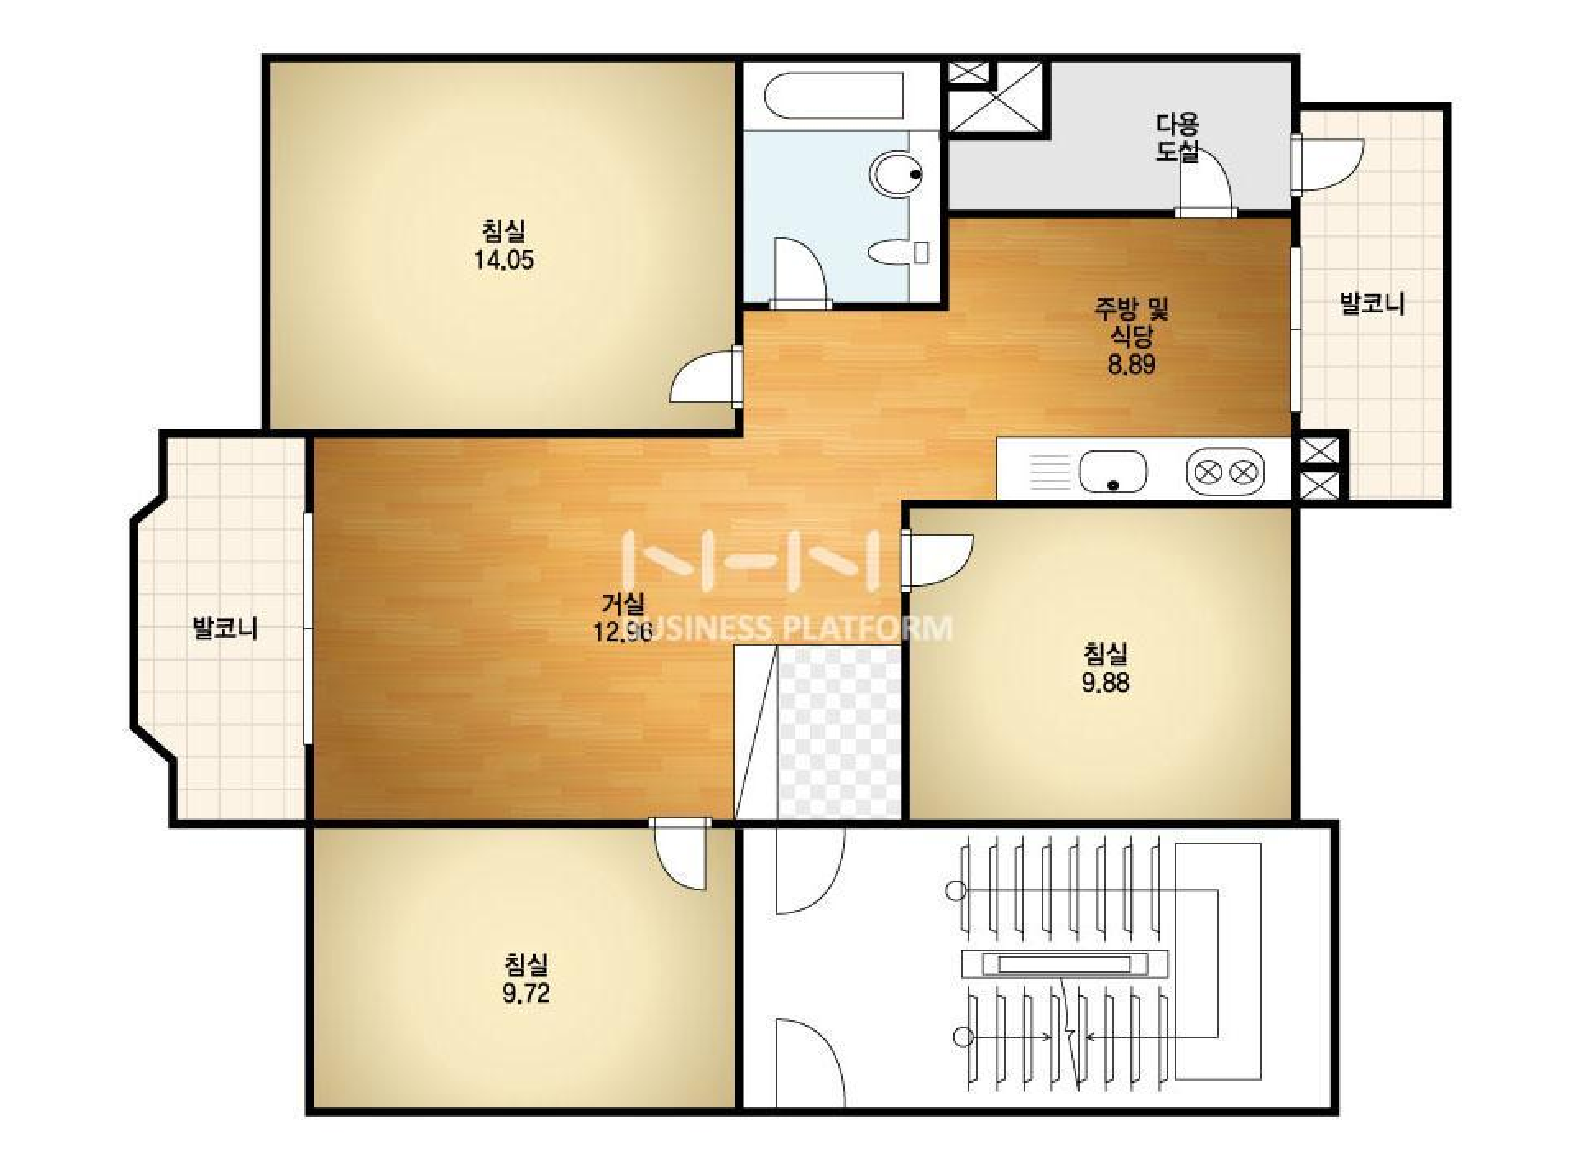

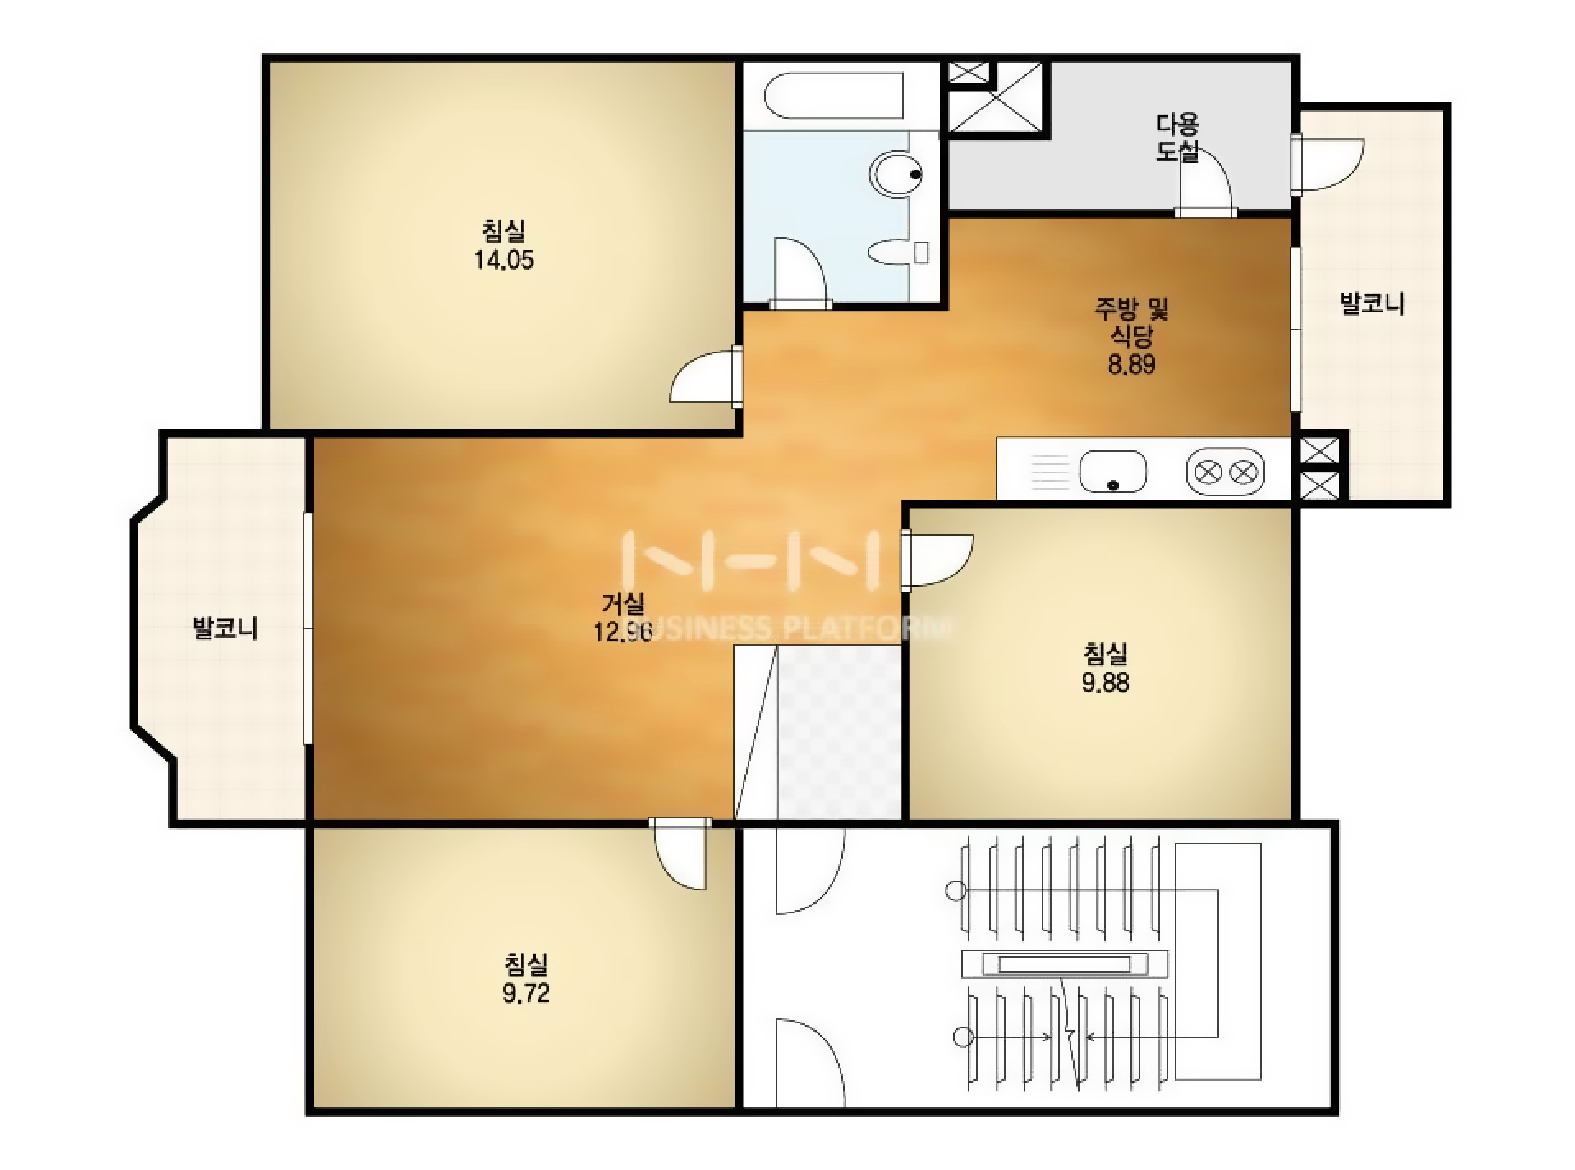

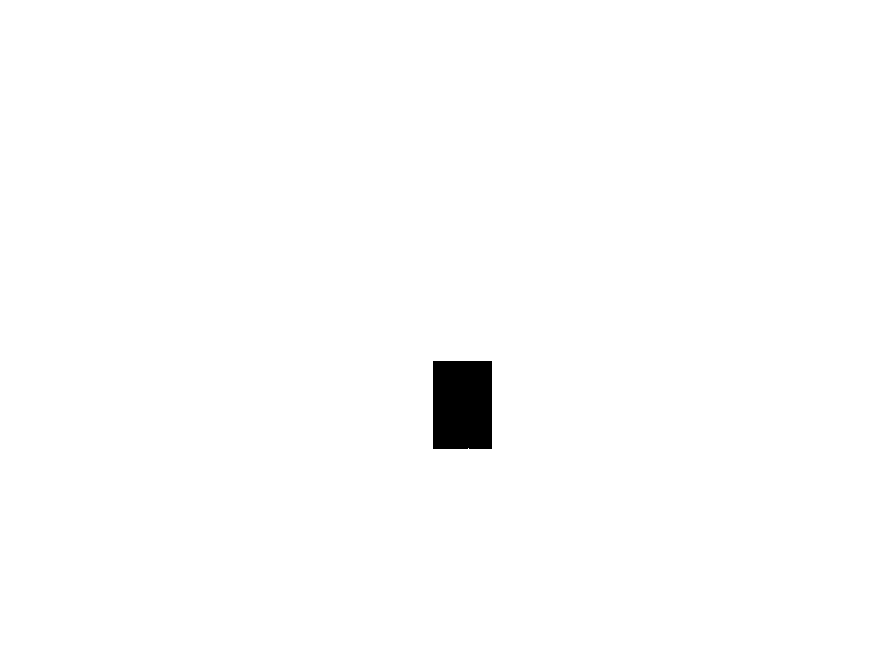

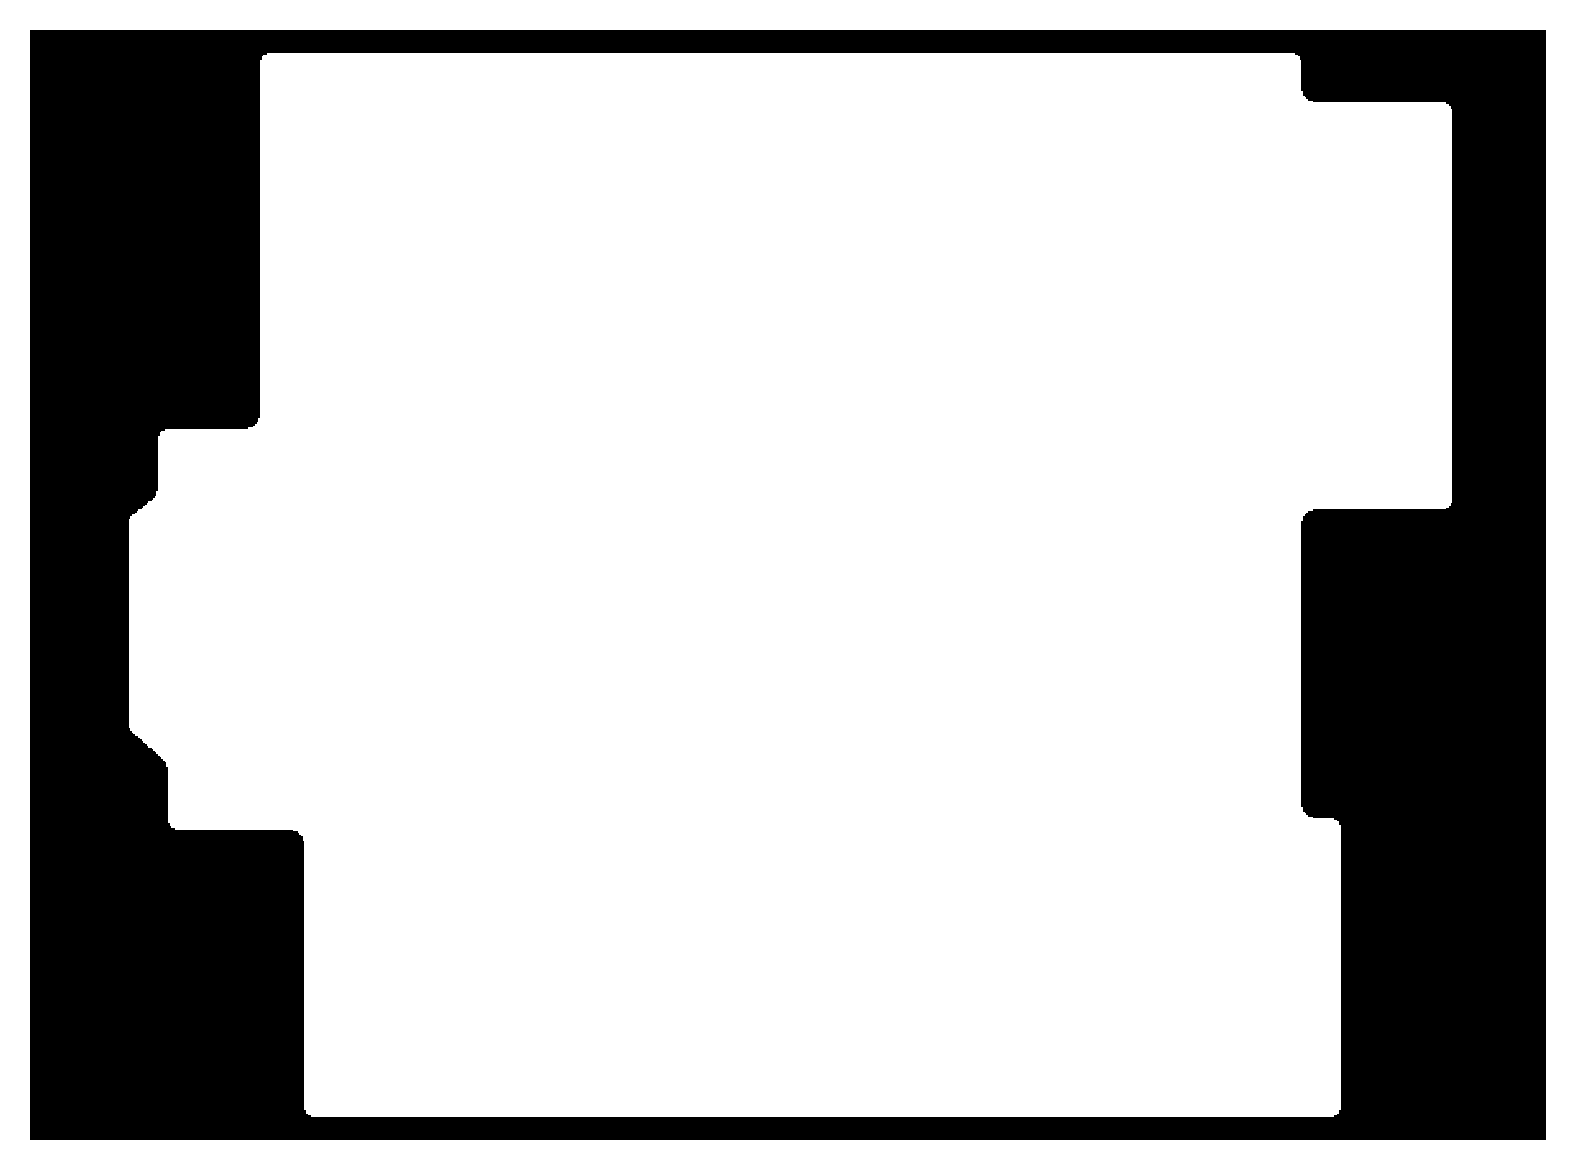

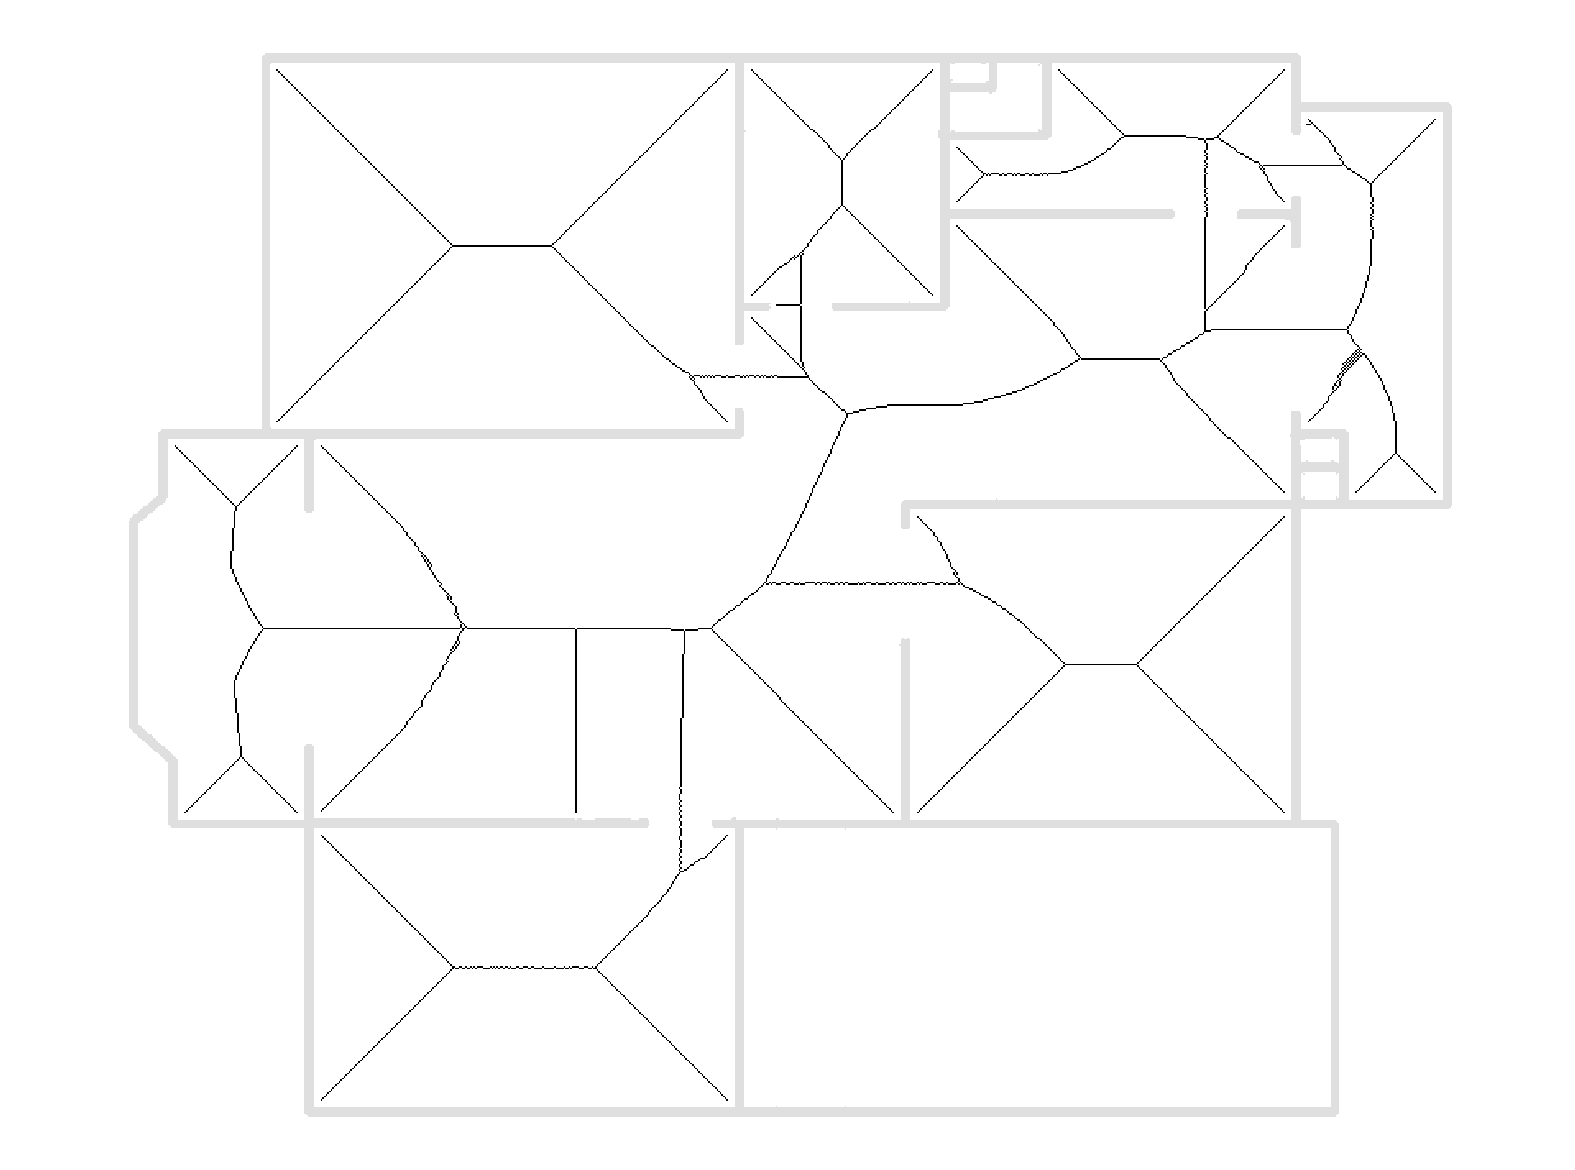

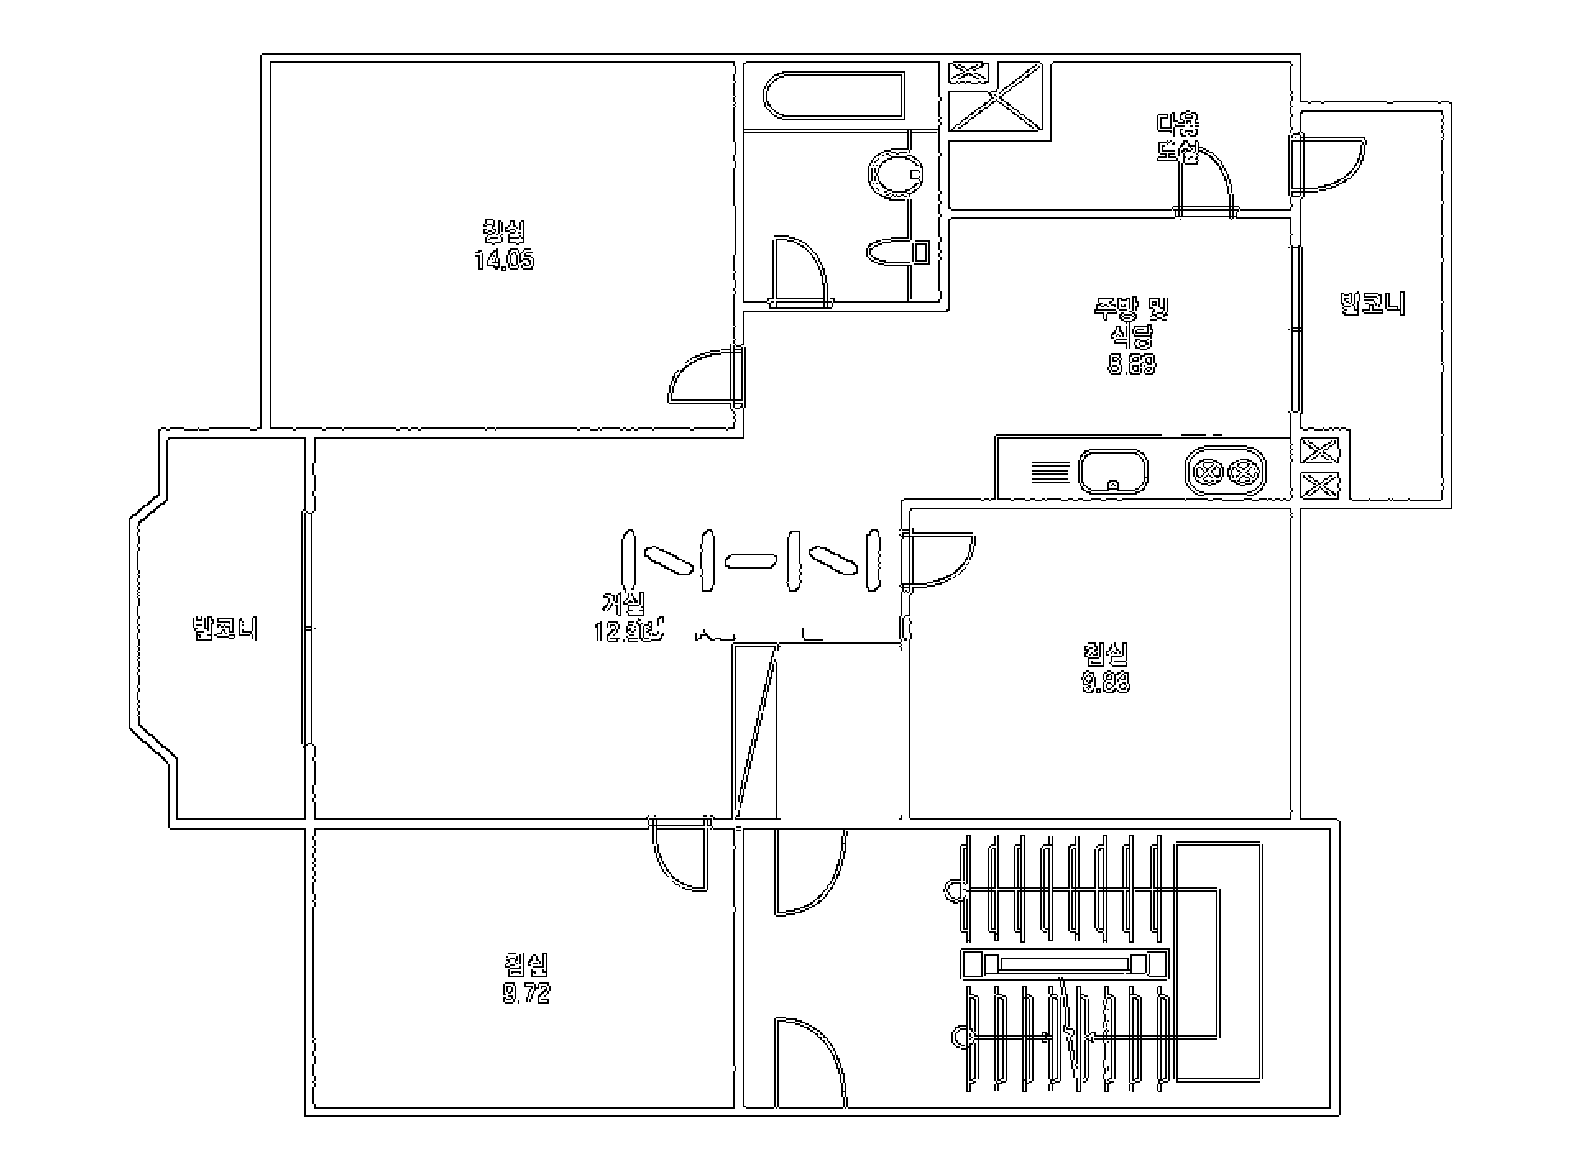

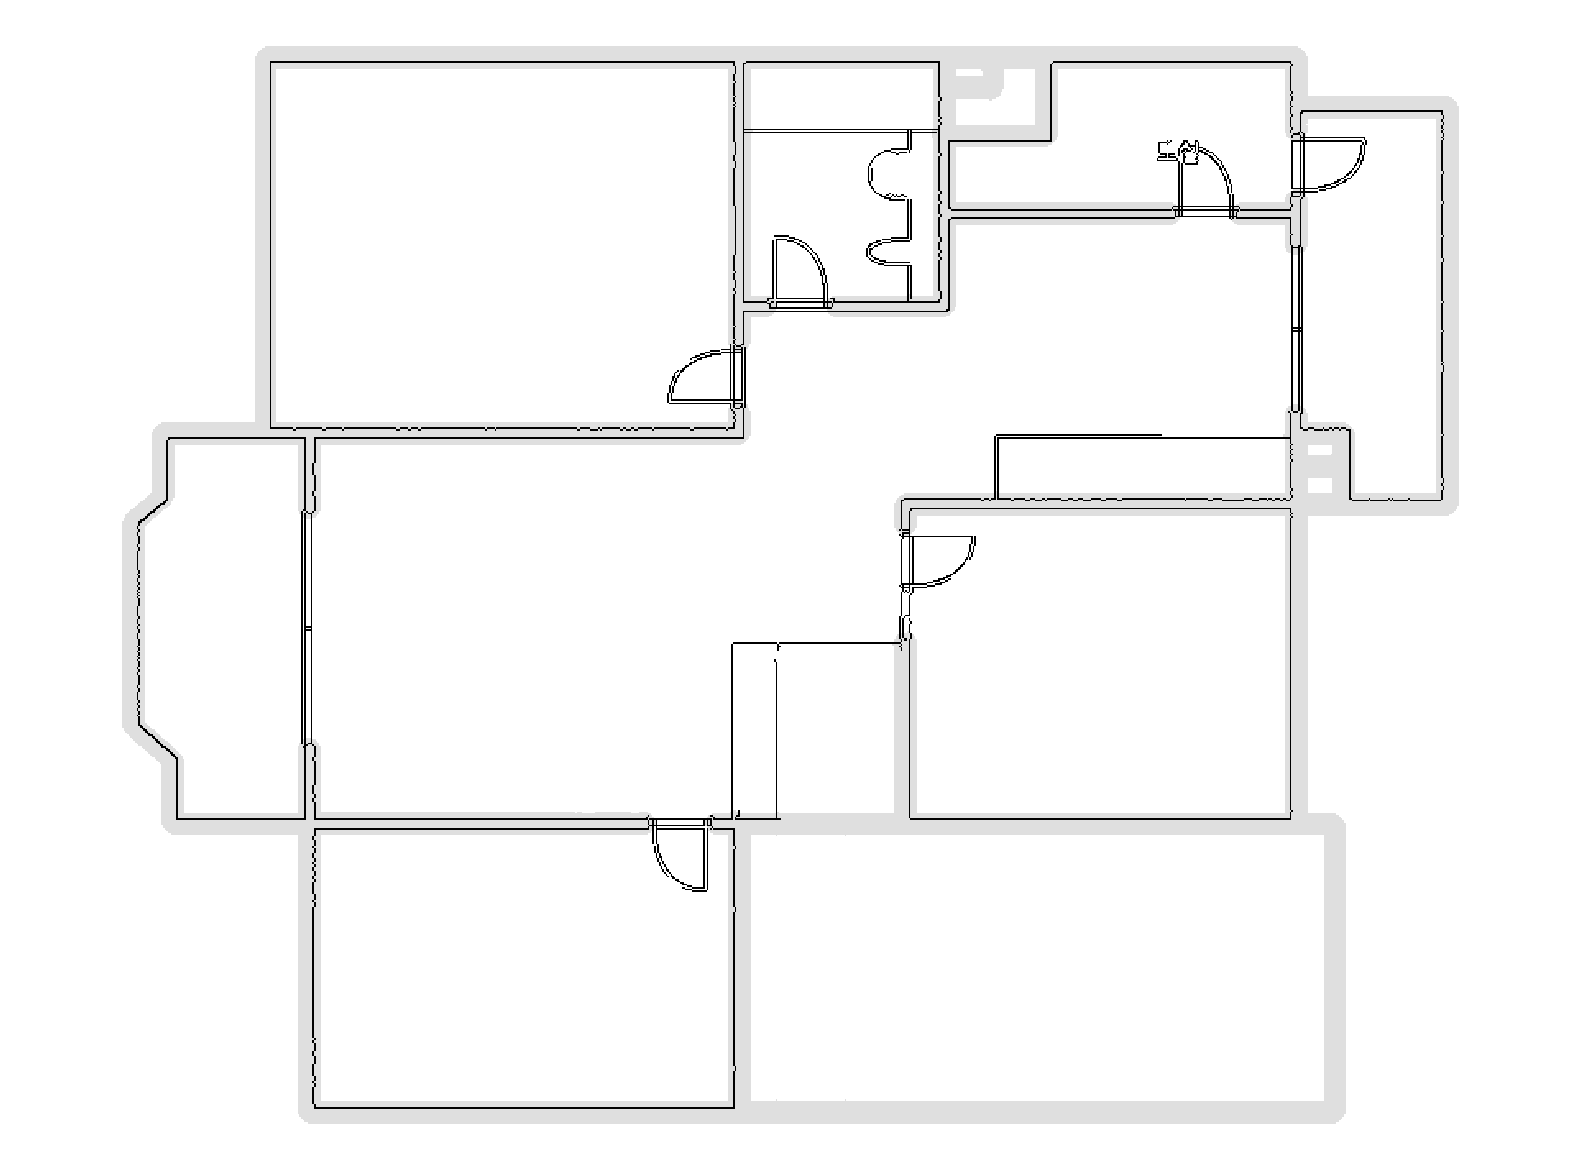

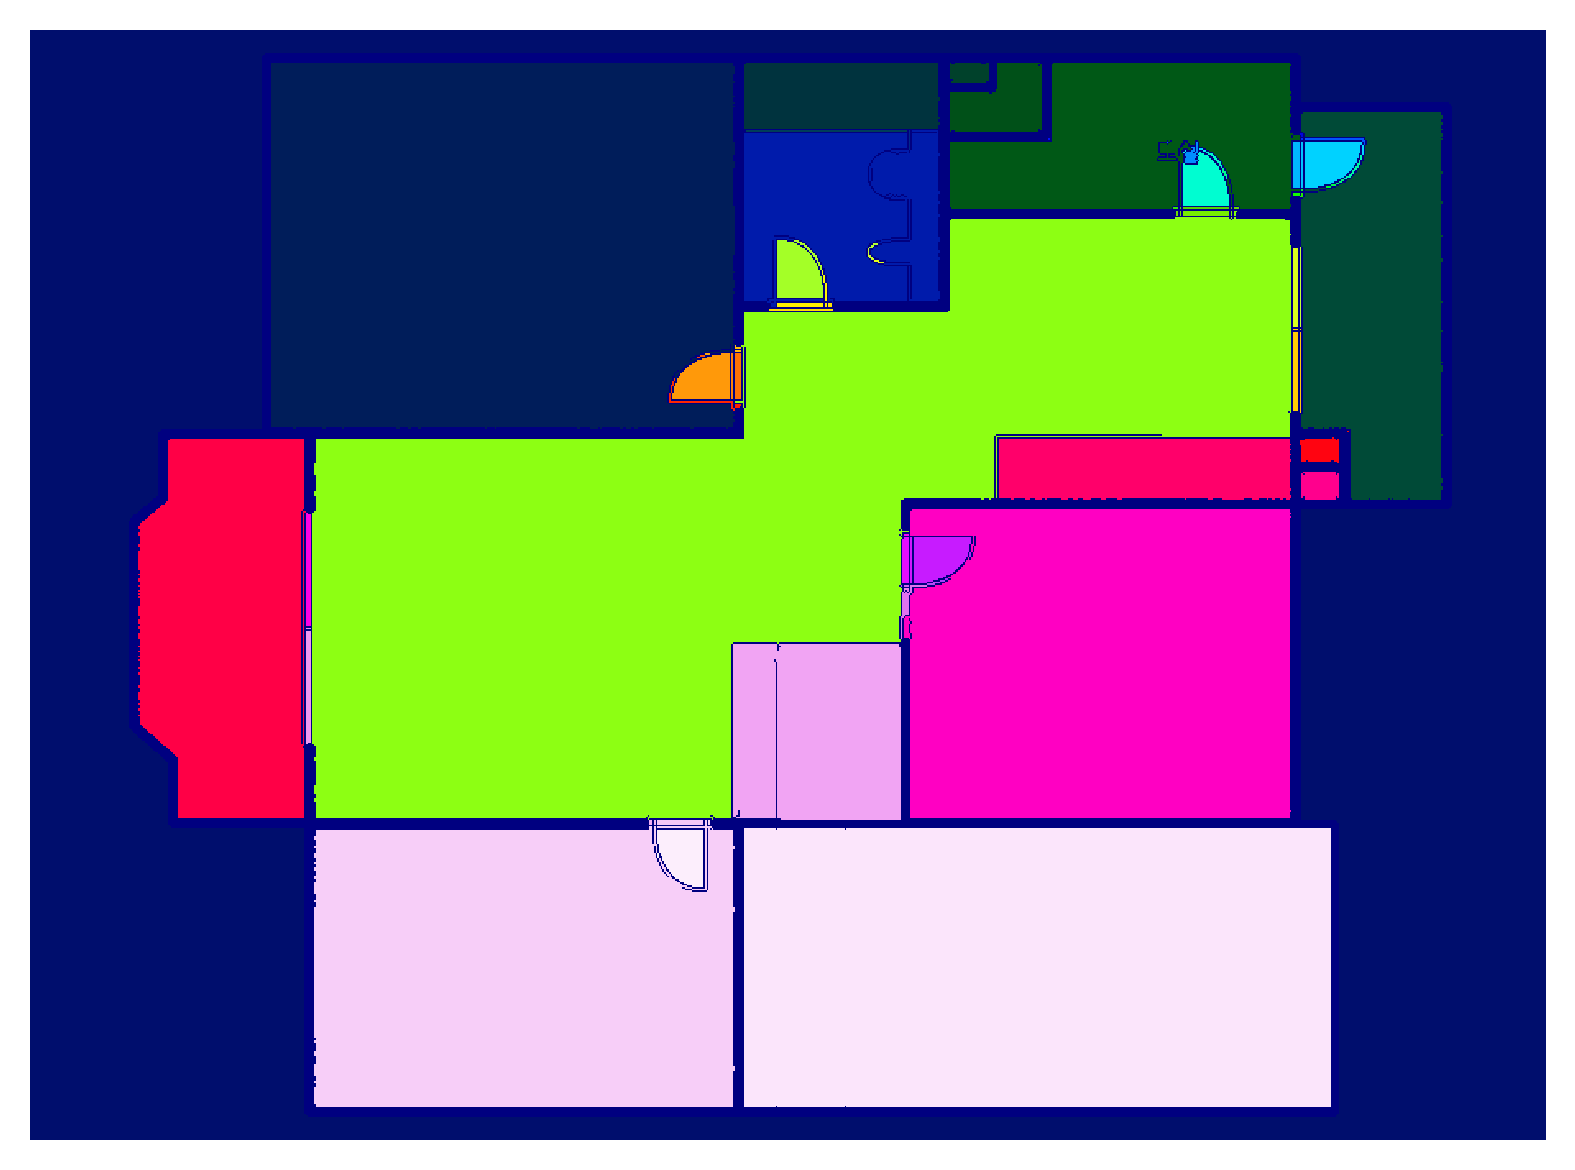

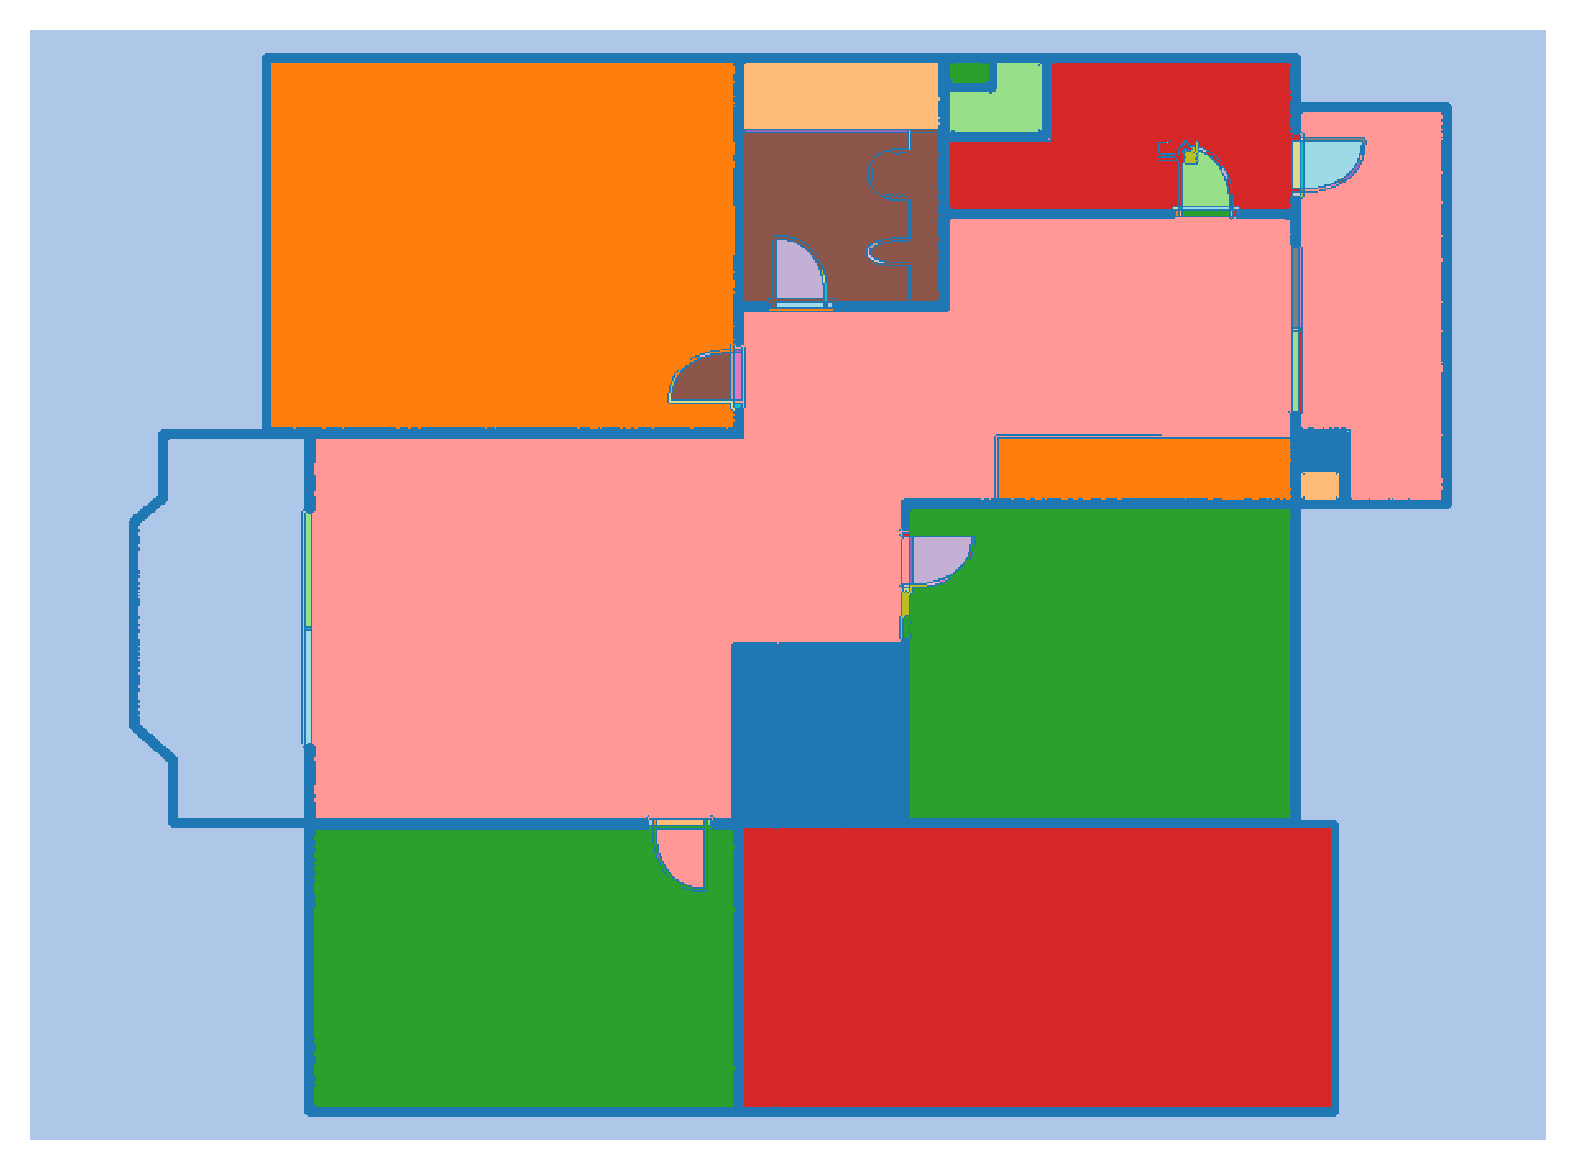

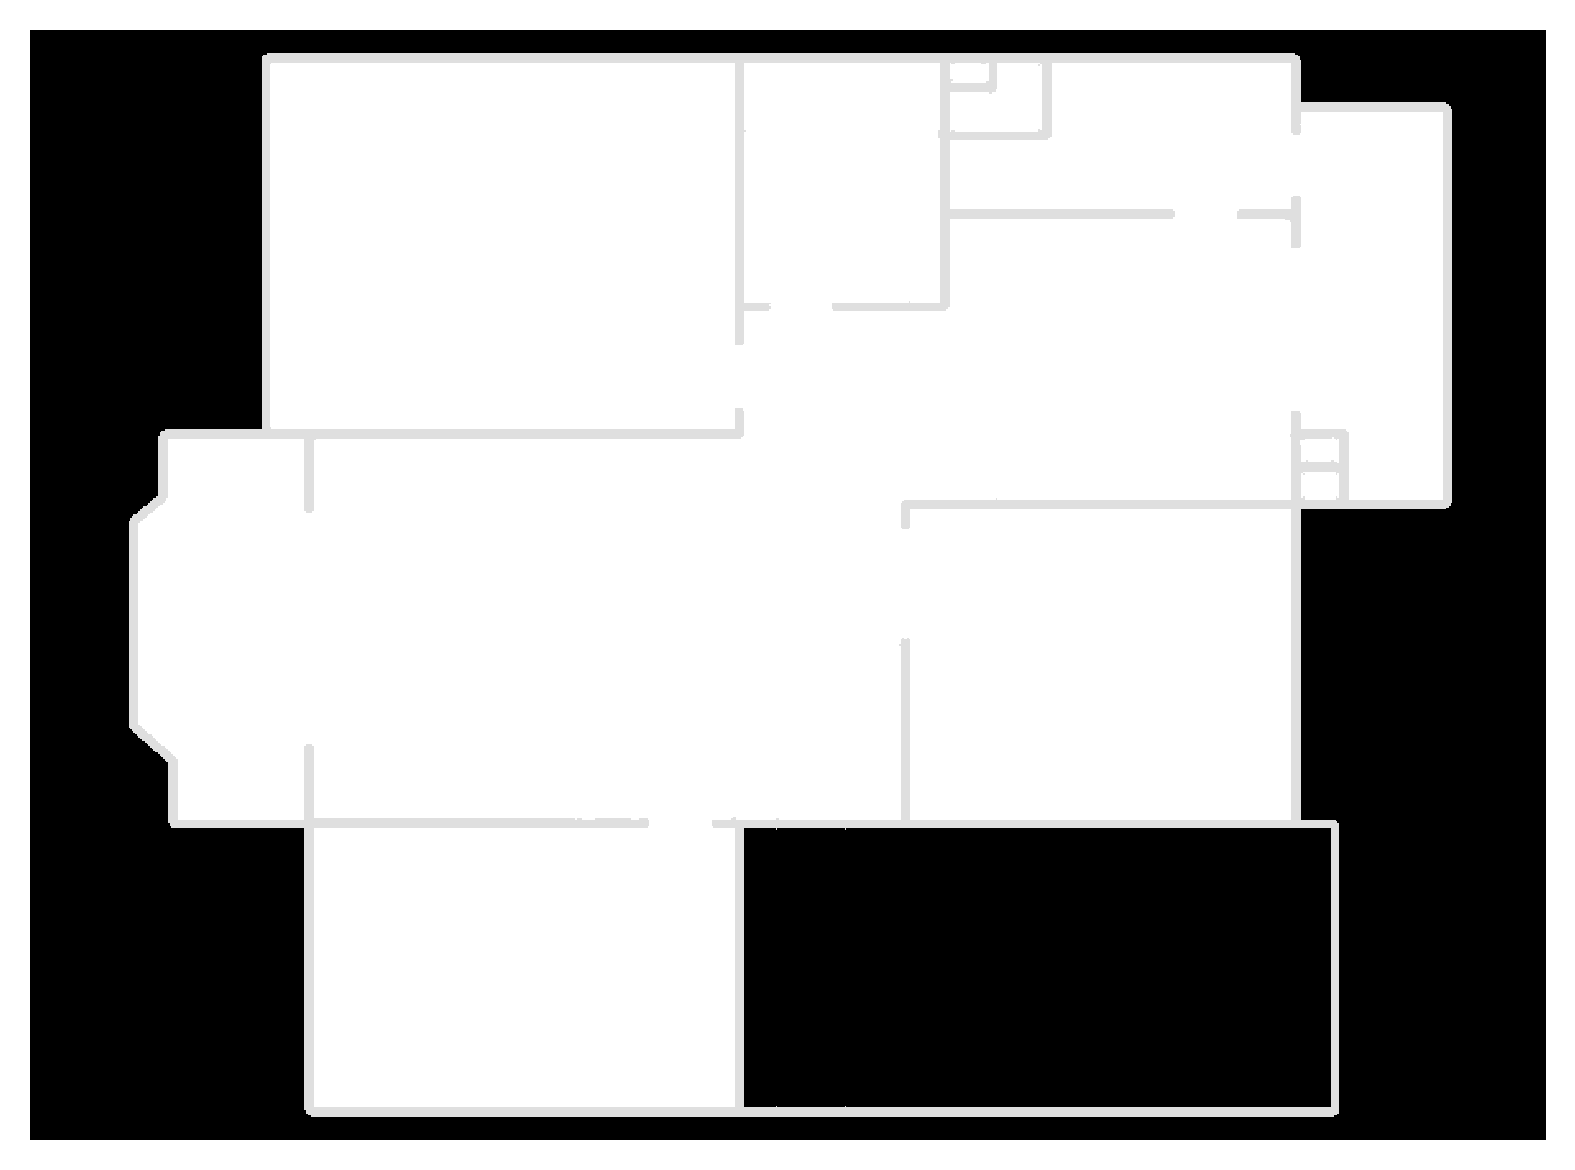

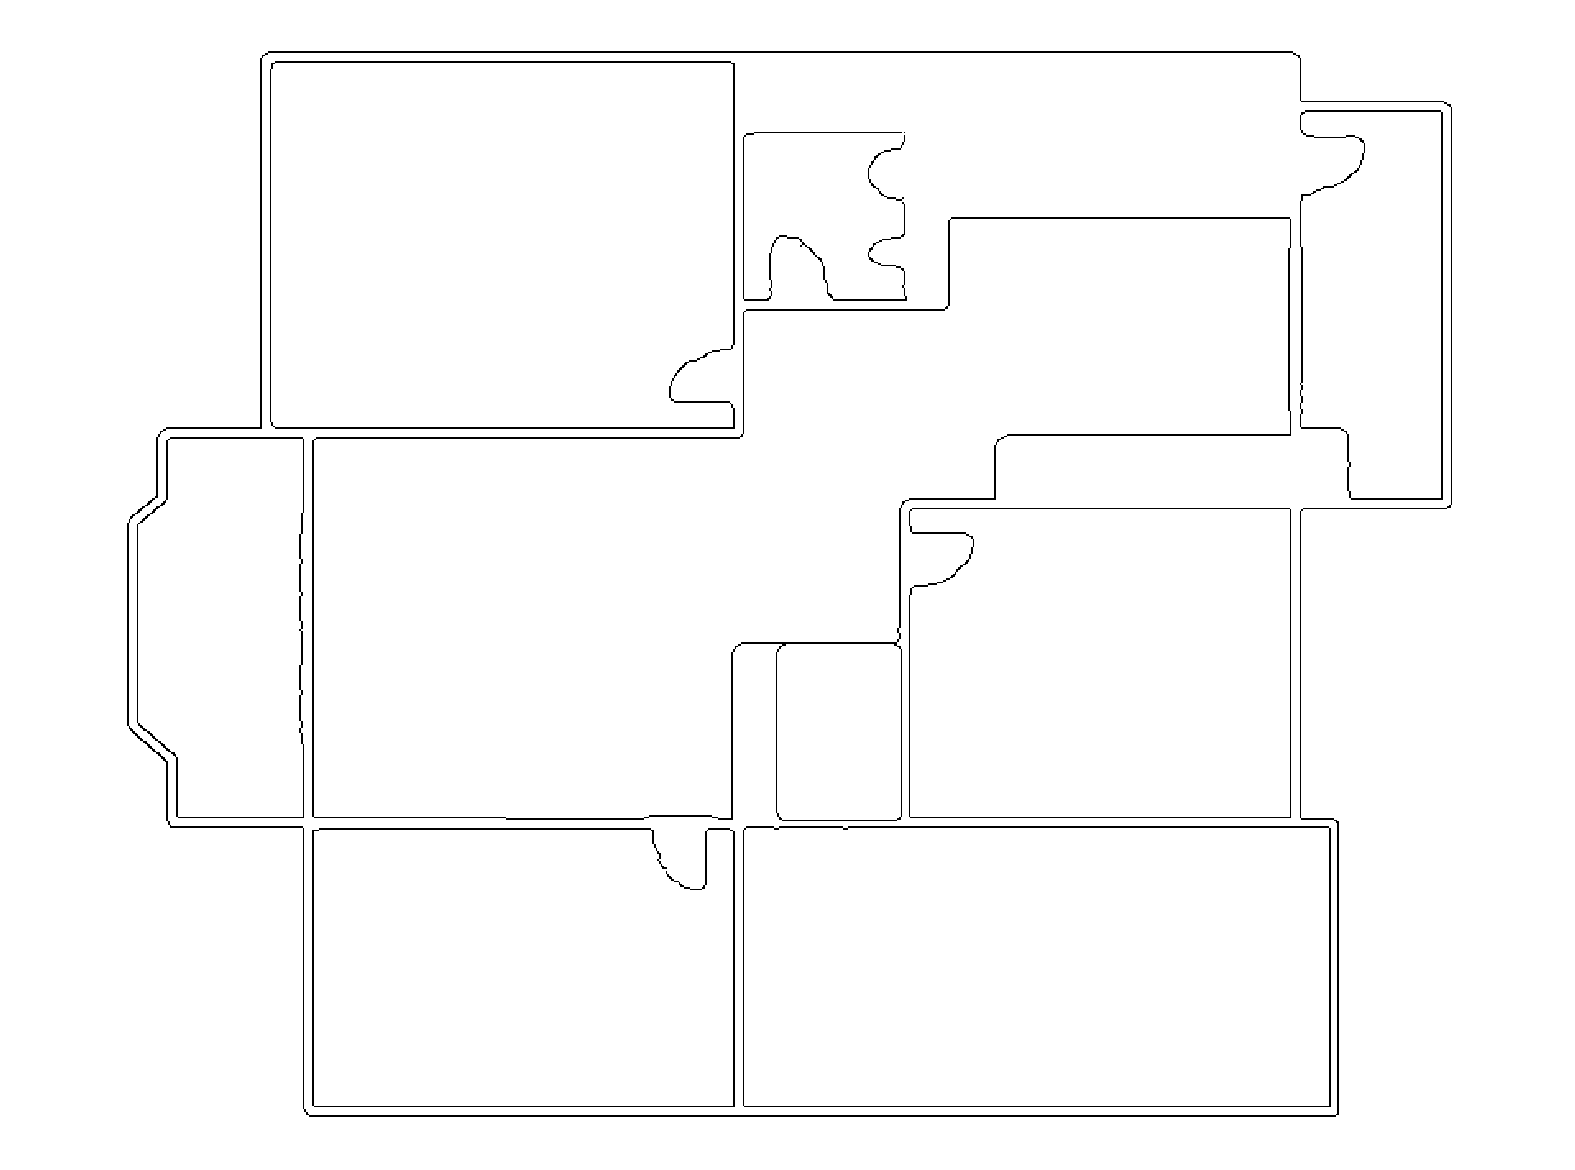

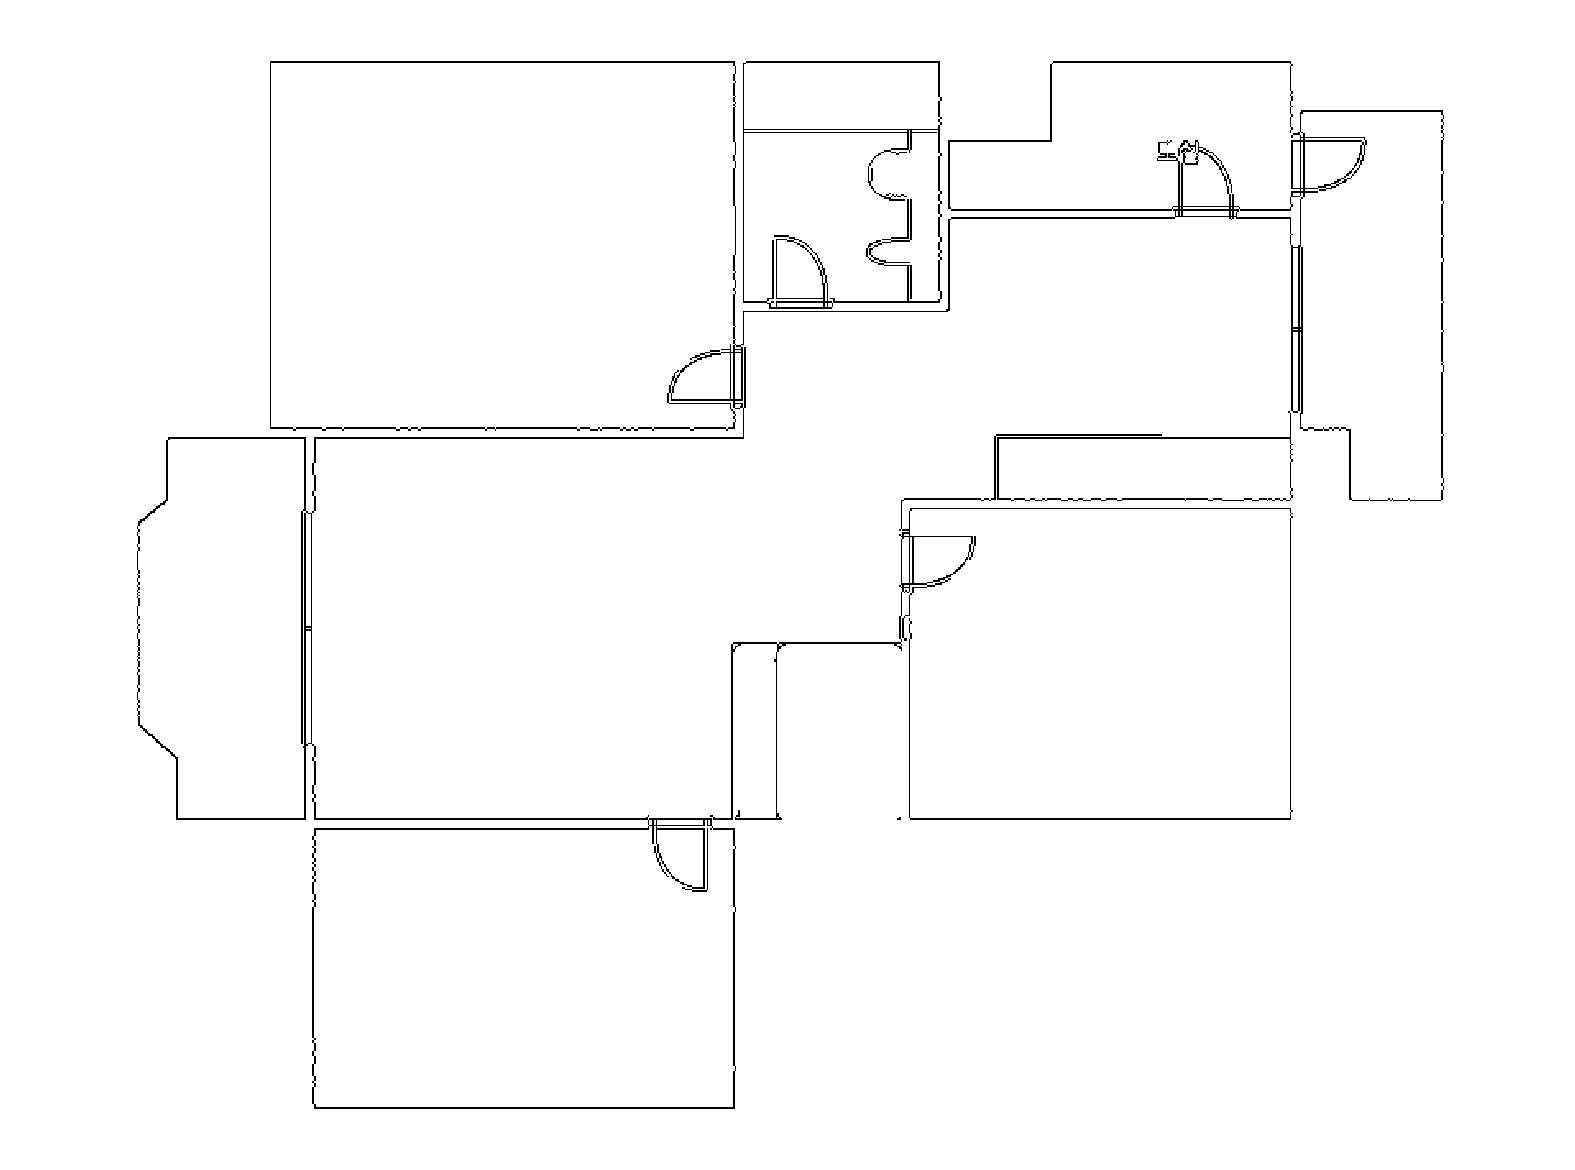

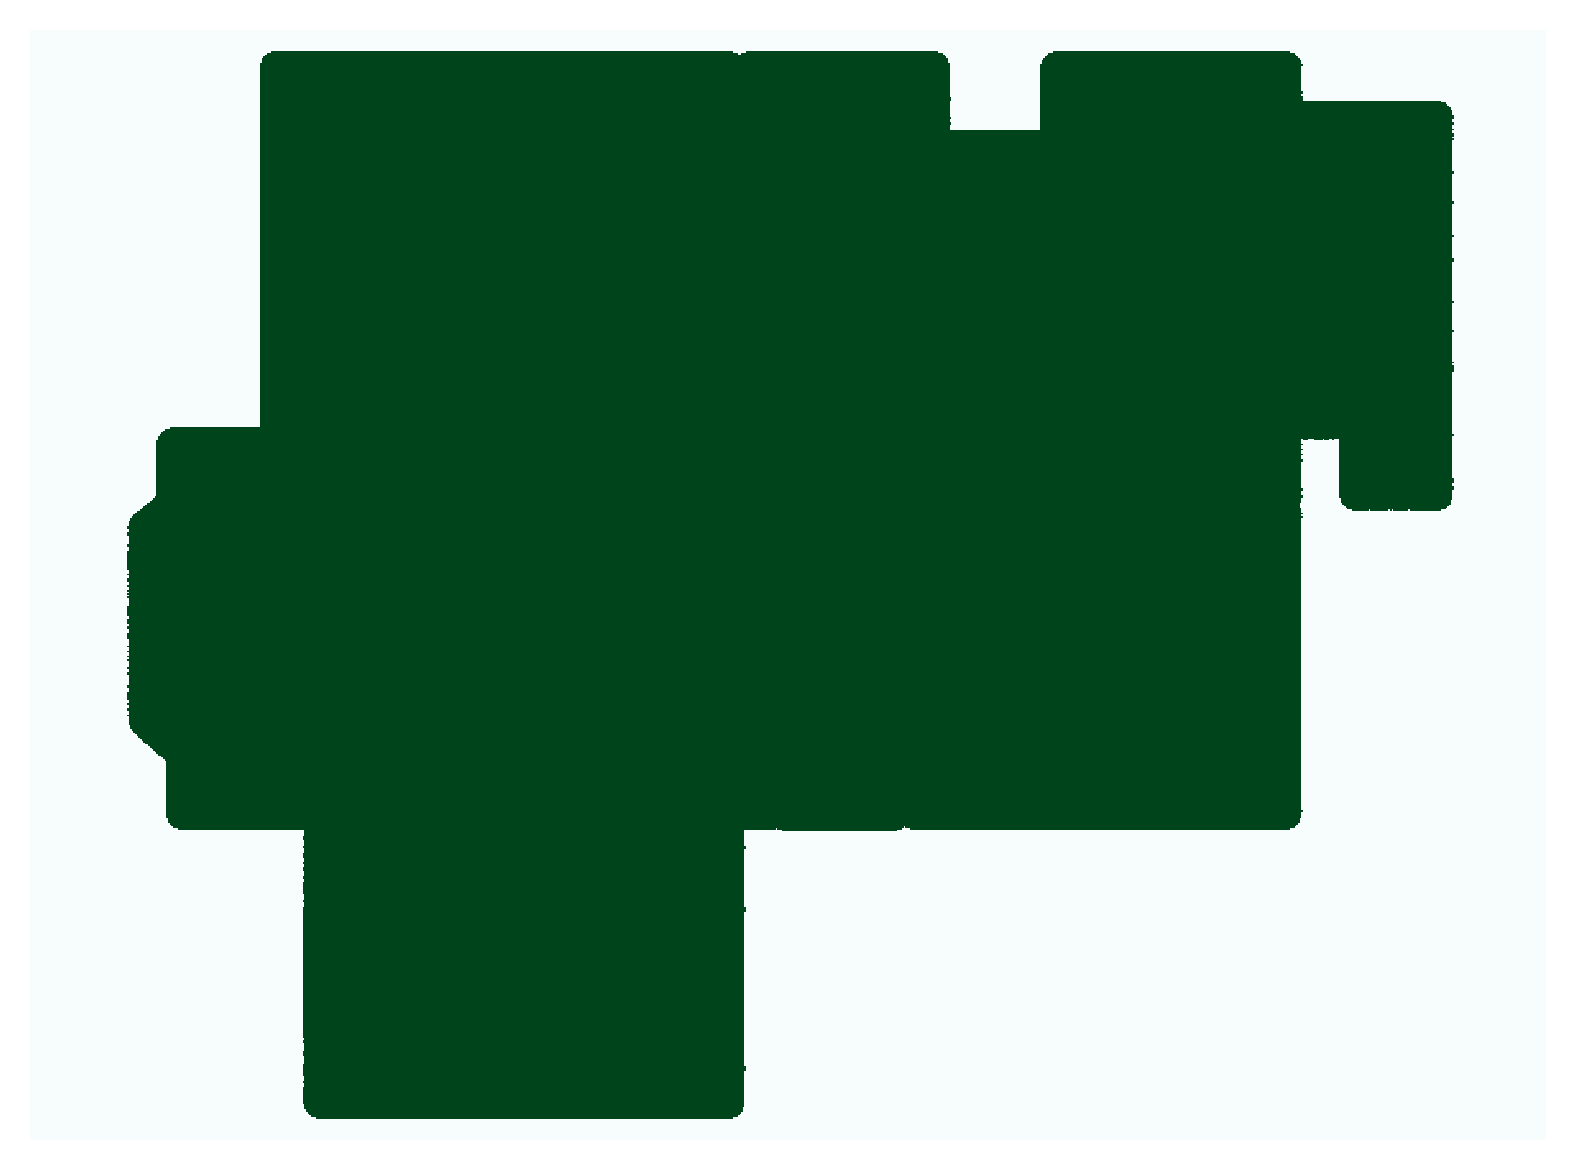

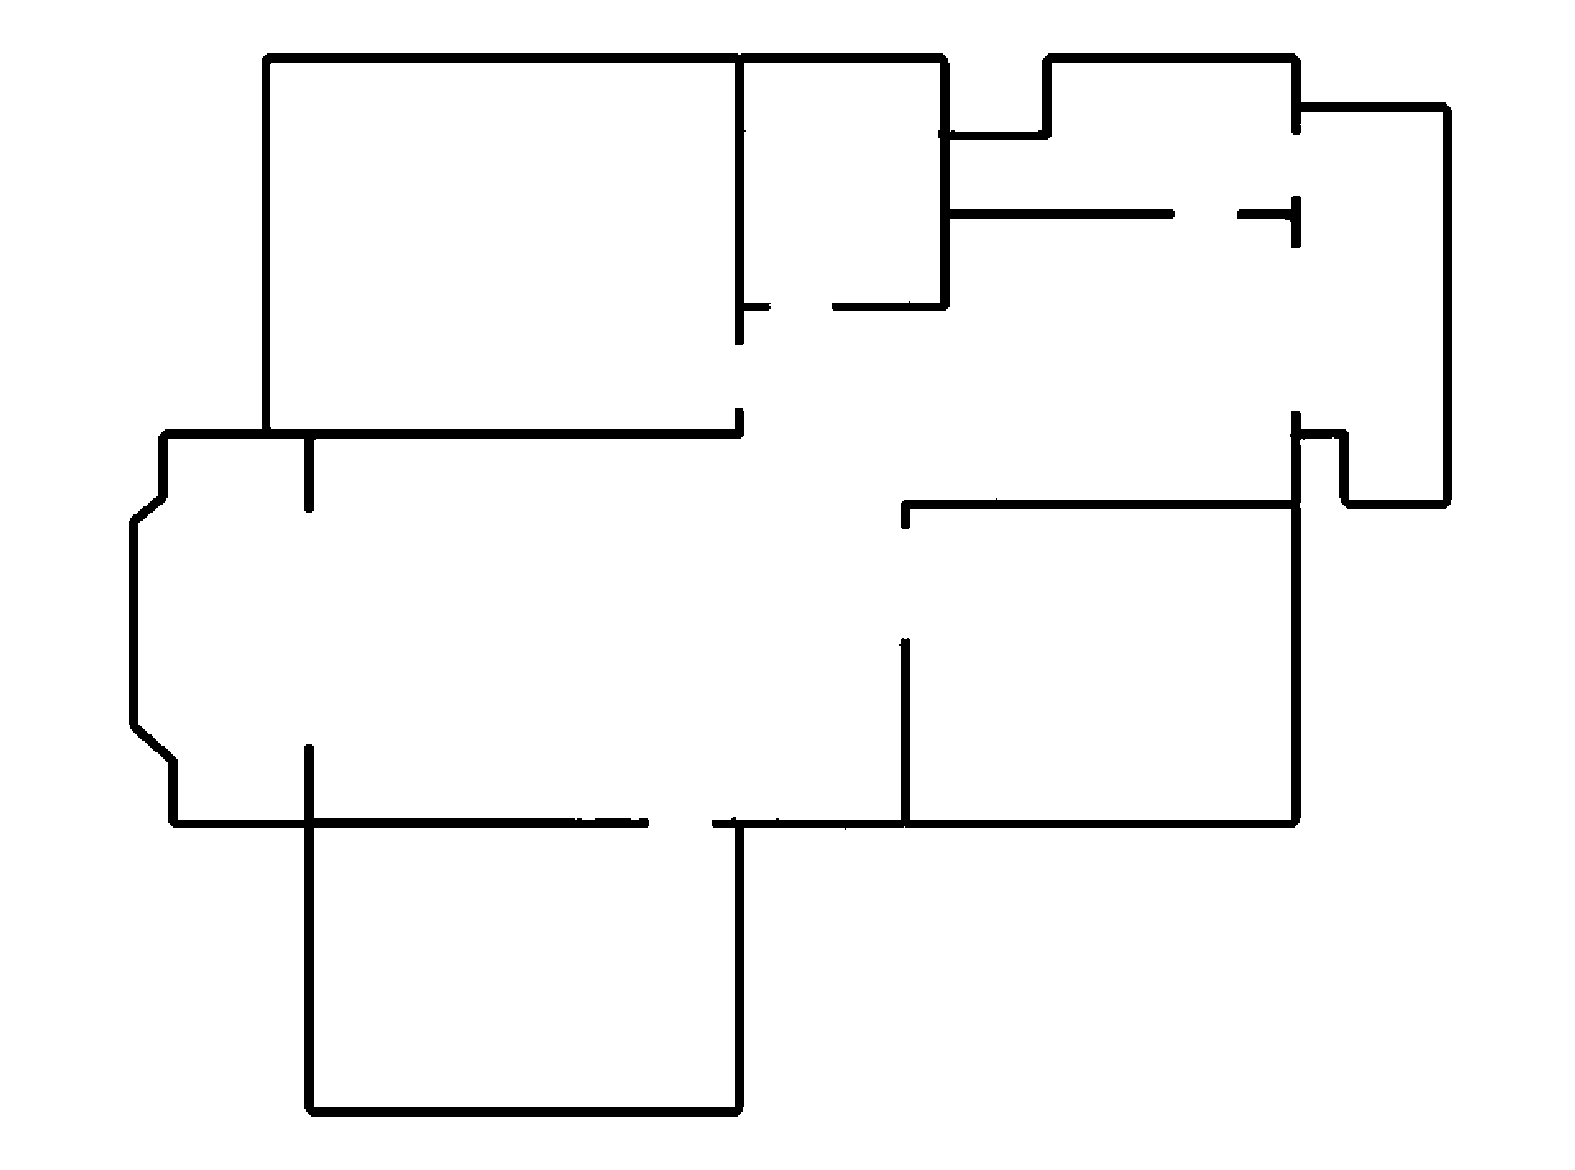

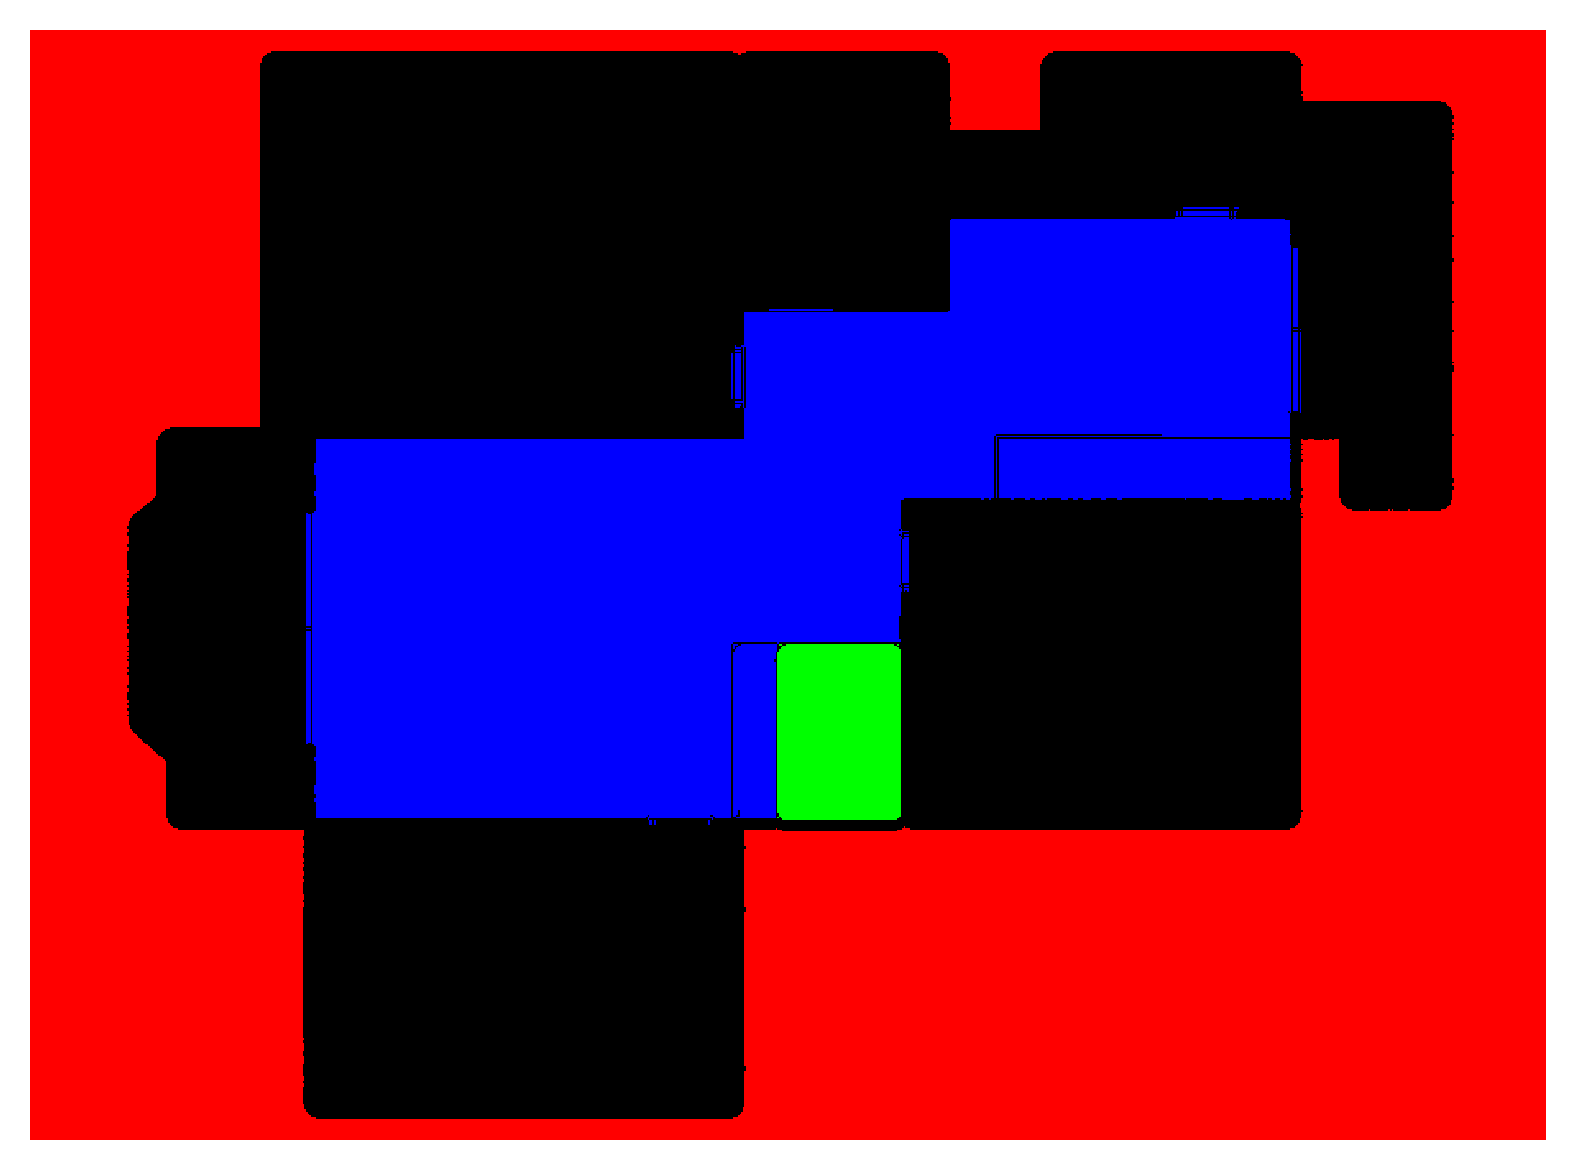

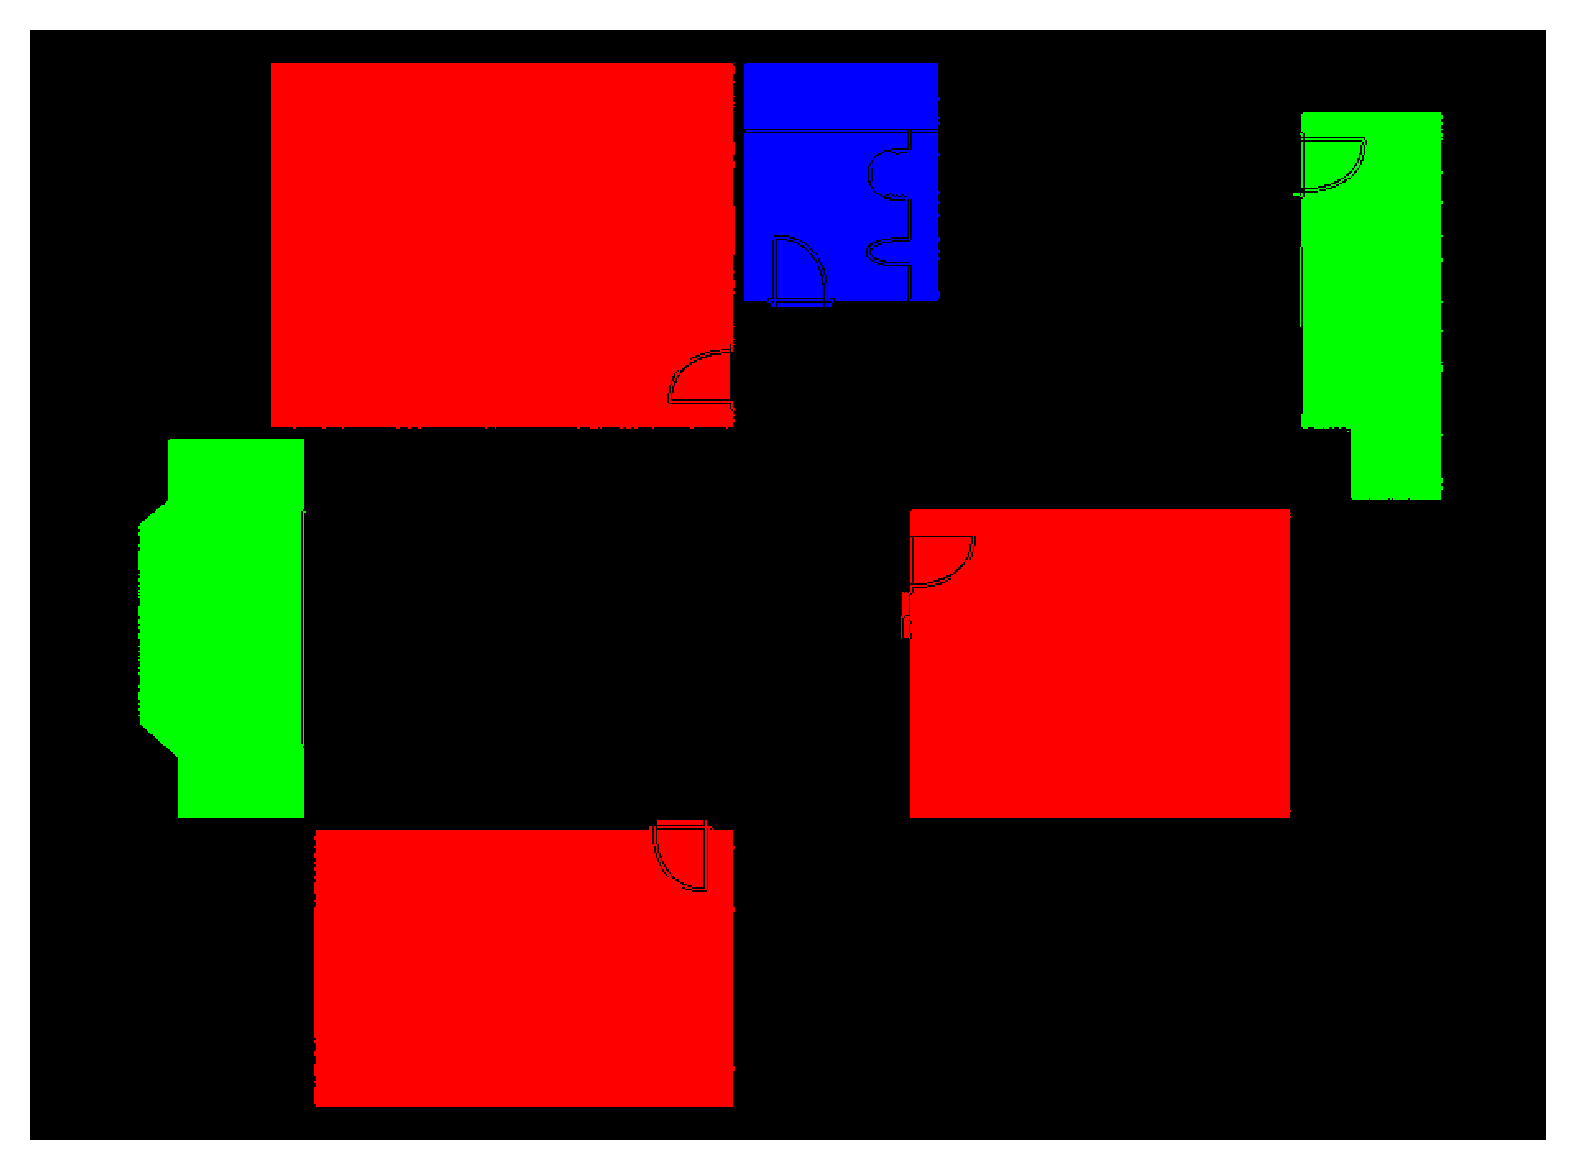

In [10]:
unit_comb_orig = get_unit_mask(bgr)

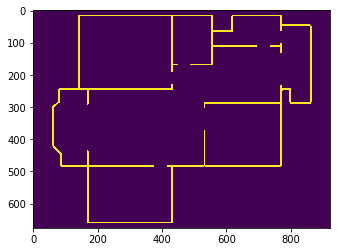

In [11]:
plt.imshow(unit_comb_orig[:, :, 0])

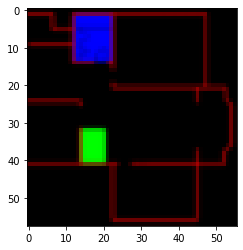

In [12]:
unit_comb = align_fp(unit_comb_orig.copy()[:,:700,:])
unit_comb = rescale_fp(unit_comb, 85)

plt.imshow(unit_comb[:, :, [0,1,5]])

{'m00': 39682.0,
 'm10': 17678023.0,
 'm01': 10669411.0,
 'm20': 12725014067.0,
 'm11': 3370123294.0,
 'm02': 3432736215.0,
 'm30': 10212713397511.0,
 'm21': 2126105053168.0,
 'm12': 805421291836.0,
 'm03': 1220395873495.0,
 'mu20': 4849592032.109394,
 'mu11': -1383016493.6733284,
 'mu02': 564021657.0916028,
 'mu30': 222907180076.32422,
 'mu21': -63059058835.72046,
 'mu12': 19875024507.143982,
 'mu03': -5873751958.407471,
 'nu20': 3.0797686932095707,
 'nu11': -0.8782946835952549,
 'nu02': 0.35818605571391676,
 'nu30': 0.7106244990147376,
 'nu21': -0.2010312636772452,
 'nu12': 0.06336125793910642,
 'nu03': -0.018725426616365334}

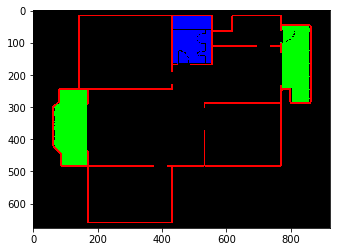

In [13]:
unit_test = unit_comb_orig.copy()
# unit_test[:, 700:, :] = 0
plt.imshow(unit_test[:, :, [0,4,5]])

cv2.moments(unit_test[:, :, 4], True)

In [14]:
# AREA_WALL = 64
# AREA_ENTRANCE = 32
# AREA_LDK = 16
# AREA_BEDROOM = 8
# AREA_BALCONY = 4
# AREA_BATHROOM = 2

mask_bits = np.array([64, 32, 16, 8, 4, 2], dtype=np.uint8)

In [15]:
cut = np.array([np.average(unit_comb[:,:,i][np.nonzero(unit_comb[:,:,i]>0)]) for i in range(6)])

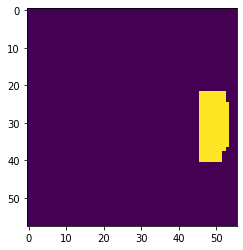

In [16]:
plt.imshow((unit_comb>cut)[:,:,4])

In [17]:
mono = ((unit_comb>cut)*255)&mask_bits

In [18]:
mono.shape, mono.dtype

((58, 56, 6), dtype('int64'))

In [19]:
np.amax(mono[:,:,2])

16

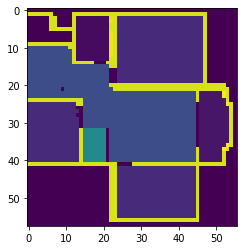

In [20]:
mono = np.bitwise_or.reduce(mono, 2)
plt.imshow(mono)

In [21]:
def mono_fp(unit_comb):
    """create bit mask image from 
    wall/entrance/LDK/bedroom/balcony/bathroom stacked array"""
    
    # AREA_WALL = 64
    # AREA_ENTRANCE = 32
    # AREA_LDK = 16
    # AREA_BEDROOM = 8
    # AREA_BALCONY = 4
    # AREA_BATHROOM = 2

    mask_bits = np.array([64, 32, 16, 8, 4, 2], dtype=np.uint8)
    
    # binary cut value
    cut = np.array([np.average(unit_comb[:,:,i][np.nonzero(unit_comb[:,:,i]>0)]) for i in range(6)])
    
    mono = ((unit_comb>cut)*255)&mask_bits
    mono = np.bitwise_or.reduce(mono, 2)
    return mono

# main